### This notebook presents code to accompany the paper

# A flexible data and knowledge-driven method for identifying climate drivers to predict summer conditions in China’s Northeast Farming Region 
Edward POPE$^{1}$*, 
Nathan CREASER$^{1}$, 
Kevin DONKERS$^{1}$, 
Andrew COTTRELL$^{1}$, 
Jemma DAVIE$^{1}$, 
Chris KENT$^{1}$, 
Catherine BRADSHAW$^{1}$, 
James BACON$^{1}$, 
Samantha ADAMS$^{1}$, 
Tom CROCKER$^{1}$, 
Peiqun ZHANG$^{2}$, 
Zhan TIAN$^{3}$

$^{1}$ Met Office, Exeter, EX1 3PB, UK<br>
$^{2}$ Beijing Climate Centre, China Meteorological Administration, Beijing, China<br>
$^{3}$ School of Environmental Science and Engineering, Southern University of Science and Technology, Shenzhen, China<br>
\* Corresponding author: edward.pope@metoffice.gov.uk 

## Table of Contents

This notebook contains all the nessacary methods to conduct the approach outlined in the paper:

### Section 1: [Feature collection](#section_1)
* Standardising and detrending data 

### Section 2: [Feature filter](#section_2)
* Remove all features that are very poorly correlated with temperature

### Section 3: [Feature selection](#section_3)
* Run the rest through the random forest to find the most useful features 

### Section 4: [Feature refinement](#section_4)
* Creating Bayseian Networks between selected jet and climate indices 
    
### Section 5: [Feature explainability](../Dynamics/2D_correlation_plots.ipynb) (not in this notebook)
* See `./Dynamics/2D_correlation_plots.ipynb`

### Section 6: [Statistical forecast](#section_6)
* Linear Regression

<a id='section_1'></a>
## Section 1: Feature collection
* Standardising and detrending data 

#### Regional temperature data
Annual JJA 2m air temperature was collected from ERA5 for each province in the NFR, weighted to maize harvest area for the year 2000 (Monfreda et al, 2008). The data is available as a CSV file: [`data/csv/temp_jja_NE_china.csv`](../data/csv/temp_jja_NE_china.csv). Information on the source of the data can be found in [`data/README.md`](../data/README.md). 

#### Climate index data
In this work we collect around 25 different climate indices on monthly timescales. To simplify this notebook the climate indices have been collated into a single CSV file: [`data/csv/climate_indices.csv`](../data/csv/climate_indices.csv). Information on the climate indices and their sources can be found in [`data/README.md`](../data/README.md), including abbreviation expansions. 

Monthly climate indices are identified by their month and abbreviation in the format <abbreviation>-<month_number> e.g. `peu-5` represents Polar Eurasian index in May. Take note that years identified for each index are for the months **preceeding** boreal summer of that year. For example, `wpsh-9` in the 1981 row represents the WPSH index in November 1980.

#### Detrending 

Firstly we detrend our data with a linear model. This ensures our data is stationary by removing any nonstationarities, such as the influence of climate change. 

#### Standardising 

Secondly we standardise our data, which sets `mean = 0, standard deviation = 1` for each variable

### Regional temperature data

Load annual JJA temperature for provinces in NFR from CSV file

In [3]:
temp_jja_fname = '../data/csv/temp_jja_NE_China_1981-2016.csv'
temp_jja = read.csv(temp_jja_fname, header = TRUE, sep = ",", stringsAsFactors = FALSE)
head(temp_jja)

,Liaoning,Jilin,Heilongjiang
,<dbl>,<dbl>,<dbl>
1981,22.61073,21.62084,20.11407
1982,22.96797,22.92326,21.90634
1983,22.26246,20.61599,19.13693
1984,22.61542,21.94940,20.54990
1985,22.32568,21.85647,20.67396
1986,21.77447,21.17251,20.37019


Rename, detrend and standardise data for each region.
- Detrending uses `lm` function
- Standardisation uses `scale` function

In [4]:
temp_anoms = array(NA, c(dim(temp_jja)[1], dim(temp_jja)[2]))
colnames(temp_anoms) = paste(colnames(temp_jja),"-T", sep="")

for (k in 1:length(colnames(temp_anoms))) {
    timesteps = 1:length(temp_jja[,k])
    detrend = lm(temp_jja[,k] ~ timesteps)$residuals
    standardised = scale(detrend)
    temp_anoms[,k] = standardised
}  

head(temp_anoms)

Liaoning-T,Jilin-T,Heilongjiang-T
0.4767537,-0.07799843,-0.53412111
1.0461054,1.81619148,2.06508026
-0.1926158,-1.65087332,-2.06402876
0.3694542,0.28934417,-0.02428095
-0.1619110,0.11110493,0.11437196
-1.1381192,-0.94495550,-0.37800865


### Climate index data

Load monthly climate index data from CSV file, renaming replacing `.` with `-` in the column names

In [6]:
climate_indices_fname = '../data/csv/climate_indices_1981-2016.csv'
climate_indices = read.csv(climate_indices_fname, header = TRUE,sep = ",", stringsAsFactors = FALSE)
colnames(climate_indices) <- gsub("[[:punct:]]", "-", colnames(climate_indices))
head(climate_indices)

,wpsh-9,wpsh-10,wpsh-11,wpsh-12,wpsh-1,wpsh-2,wpsh-3,wpsh-4,wpsh-5,iod-9,⋯,mjopc1b-5,amo-9,amo-10,amo-11,amo-12,amo-1,amo-2,amo-3,amo-4,amo-5
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1981,14647.72,14855.22,14874.19,14754.29,14840.38,14823.92,14974.42,14865.94,14733.79,-0.639,⋯,0.3135853,-0.14,-0.15,-0.15,-0.15,-0.15,-0.16,-0.16,-0.16,-0.16
1982,14724.16,14813.61,14881.97,14928.39,14844.86,14816.04,14831.94,14822.94,14803.69,-0.651,⋯,-0.8869489,-0.16,-0.17,-0.17,-0.17,-0.17,-0.17,-0.17,-0.16,-0.16
1983,14697.37,14787.07,15000.44,14983.69,15086.88,14982.15,14953.99,14939.12,14837.90,0.548,⋯,-1.2200562,-0.16,-0.16,-0.16,-0.16,-0.16,-0.16,-0.16,-0.16,-0.16
1984,14788.31,14886.98,14866.77,14894.84,14774.50,14744.34,14836.41,14743.72,14685.91,0.037,⋯,1.0038773,-0.15,-0.15,-0.15,-0.15,-0.15,-0.15,-0.15,-0.15,-0.15
1985,14756.51,14682.57,14898.16,14755.96,14815.74,14657.85,14918.78,14622.10,14663.60,-0.502,⋯,0.9774278,-0.15,-0.15,-0.15,-0.15,-0.15,-0.15,-0.15,-0.15,-0.16
1986,14790.06,14870.71,14887.35,14840.96,14812.80,14745.91,14785.91,14862.11,14621.19,-0.132,⋯,-0.3579582,-0.16,-0.16,-0.16,-0.16,-0.16,-0.16,-0.16,-0.17,-0.17


Keep a list of the climate indices and months we are most interested in (will be used a lot in later sections)

In [7]:
ind_list = c("wpsh", "iod", "pdo", "nin3","seu", "nao", "snao", "scand", "ao", "eawr", "peu", "cgt", "pstratu", "mjopc1a", "mjopc1b", "amo")
mon_list = c(9,10,11,12,1,2,3,4,5)

Detrend and standardise each `cindex-month`.
- Detrend using `lm` function
- Standardise using `scale` function

In [8]:
cindex_anoms = array(NA, c(dim(climate_indices)[1], dim(climate_indices)[2]))
colnames(cindex_anoms) = colnames(climate_indices)
rownames(cindex_anoms) = rownames(climate_indices)

for (s in 1:dim(climate_indices)[2]) {
    timesteps = 1:dim(climate_indices)[1]
    detrend = lm(climate_indices[,s] ~ timesteps)$residuals
    standardised = scale(detrend)
    cindex_anoms[,s] = standardised
}

head(cindex_anoms)

,wpsh-9,wpsh-10,wpsh-11,wpsh-12,wpsh-1,wpsh-2,wpsh-3,wpsh-4,wpsh-5,iod-9,⋯,mjopc1b-5,amo-9,amo-10,amo-11,amo-12,amo-1,amo-2,amo-3,amo-4,amo-5
1981,-0.81403246,0.3908544,-0.4832602,-1.79450205,-0.5490223,-0.2333582,1.1935139,0.60339529,-0.1832748,-1.201899209,⋯,0.2940131,1.299626222,1.14105248,1.0942301,1.05689299,1.03964024,0.90265360,0.88897409,0.7729054,0.75323034
1982,0.27045373,-0.1548922,-0.3574754,0.08064204,-0.5024673,-0.3294853,-0.5197873,0.07973675,0.7816871,-1.263696128,⋯,-1.3135036,0.762324208,0.60299290,0.5619158,0.52692667,0.51459353,0.54373150,0.52593390,0.6010720,0.58203490
1983,-0.09435666,-0.5000170,1.6245257,0.67717440,2.4069856,1.3393430,0.9469850,1.46479417,1.2537764,1.890814598,⋯,-1.7531080,0.573753485,0.58878967,0.5485361,0.51414677,0.50180359,0.52872662,0.51198378,0.4292385,0.41083947
1984,1.19371570,0.8395346,-0.6218910,-0.27775697,-1.3654123,-1.0892955,-0.4670106,-0.88611513,-0.8449340,0.503718327,⋯,1.2501129,0.559548407,0.57458645,0.5351565,0.50136687,0.48901366,0.51372174,0.49803365,0.4215489,0.40374329
1985,0.75847369,-1.8752372,-0.1000867,-1.77105230,-0.8759027,-1.9828740,0.5227434,-2.35231562,-1.1530700,-0.957743439,⋯,1.2233955,0.370977684,0.38576443,0.3487986,0.31619150,0.30547146,0.32675824,0.30953850,0.2497155,0.06844861
1986,1.24078063,0.6398621,-0.2861184,-0.85493696,-0.9188377,-1.1057450,-1.0751083,0.51735794,-1.7388319,-0.004982538,⋯,-0.5656869,0.008041316,0.02232364,-0.0105375,-0.04137935,-0.04882299,-0.03216386,-0.05350168,-0.2504056,-0.26684608


In [9]:
# REDUNDANT?
# 
# ind_list_rep = rep(ind_list, each=length(mon_list)) # creates ind_list with names the length of the month i
# index_type = c("Tropical", "Tropical", "Mid-lat", "Tropical", "High-lat", "Mid-lat", "Mid-lat", "High-lat", "High-lat", "High-lat", "High-lat", "Mid-lat", "Polar-strat", "Tropical", "Tropical", "Mid-lat")
# data.class = rep(index_type, each=length(mon_list))
# names(data.class) = index_type

### East Asian jet data
Load data for the East Asian jets:
```
uwind = zonal wind
vwind = meridional wind
eapj  = East Asian Polar Jet
easj  = East Asian Subtropical Jet
```

In [10]:
ndata = "../data/csv/"
j1u = "eapj_uwind_200hPa_monthly_custom.csv"
#j1u = "eapj_uwind_200hPa_monthly_huang2014.csv"

j1v = "eapj_vwind_200hPa_monthly_custom.csv"
#j1v = "eapj_vwind_200hPa_monthly_huang2014.csv"

j2u = "easj_uwind_200hPa_monthly_custom.csv"
#j2u ="easj_uwind_200hPa_monthly_huang2014.csv"

j2v = "easj_vwind_200hPa_monthly_custom.csv"
#j2u ="easj_vwind_200hPa_monthly_huang2014.csv"

# read yield, T and P data
j1udat = read.csv(paste(ndata,j1u, sep=""), header = TRUE,sep = ",", stringsAsFactors = FALSE)
j1vdat = read.csv(paste(ndata,j1v, sep=""), header = TRUE,sep = ",", stringsAsFactors = FALSE)

j2udat = read.csv(paste(ndata,j2u, sep=""), header = TRUE,sep = ",", stringsAsFactors = FALSE)
j2vdat = read.csv(paste(ndata,j2v, sep=""), header = TRUE,sep = ",", stringsAsFactors = FALSE)

In [11]:
##### We havn't done anything with jets yet 
ystrt = 1981
yend = 2016
indyrsjet = which(j1udat[,1] == ystrt):which(j1udat[,1] == yend)

## calcaulte jja mean and de-trend
jmons = c("Mar", "Apr", "May", "Jun", "Jul", "Aug")
jmons_num = c(3,4,5,6,7,8)

j1ujja = j1udat[indyrsjet, jmons] 

colnames(j1ujja) = paste("eapju",jmons_num, sep="-")

j2ujja = j2udat[indyrsjet, jmons] 
colnames(j2ujja) = paste("easju",jmons_num, sep="-")

j1vjja = j1vdat[indyrsjet, jmons] 
colnames(j1vjja) = paste("eapjv",jmons_num, sep="-")

j2vjja = j2vdat[indyrsjet, jmons] 
colnames(j2vjja) = paste("easjv",jmons_num, sep="-")

jet_raw = as.matrix(cbind(j1ujja, j1vjja, j2ujja, j2vjja))

In [12]:
jet_anoms = array(NA, c(dim(jet_raw)[1], dim(jet_raw)[2]))
colnames(jet_anoms) = colnames(jet_raw)
rownames(jet_anoms) = rownames(cindex_anoms)

In [13]:
for (s in 1:dim(jet_raw)[2]) {
  # de-trend
  tt = 1:dim(jet_raw)[1]
  mod = lm(jet_raw[,s] ~ tt)
  jet_anoms[,s] = scale(mod$residual)
}

In [14]:
head(jet_anoms)

,eapju-3,eapju-4,eapju-5,eapju-6,eapju-7,eapju-8,eapjv-3,eapjv-4,eapjv-5,eapjv-6,⋯,easju-5,easju-6,easju-7,easju-8,easjv-3,easjv-4,easjv-5,easjv-6,easjv-7,easjv-8
1981,-0.2673068,1.2258024,-0.5146467,-1.1501056,1.43970881,-2.0421761,-0.22976396,0.1282359,-0.96941338,-0.5659394,⋯,-0.48673140,-0.6282208,-2.2073739,1.51223567,-0.22976396,0.1282359,-0.96941338,-0.5659394,-0.3153362,-1.2941930
1982,0.8123170,0.5704176,-0.8585113,0.3646483,-0.08194652,2.1049598,0.86244156,-0.3491913,-0.05873459,-0.7617309,⋯,-0.60694055,-0.3667581,0.8292086,-0.63889096,0.86244156,-0.3491913,-0.05873459,-0.7617309,-1.3284011,0.4868199
1983,-0.6832619,-0.8345114,-0.5340283,-1.4612080,0.37957390,-0.1938942,-0.43175536,1.8754094,0.24764264,0.6787895,⋯,-0.03655568,1.5908256,1.9673861,-0.89879682,-0.43175536,1.8754094,0.24764264,0.6787895,0.3055203,0.7625471
1984,-2.3025715,-0.4629560,-0.3536772,-0.2555354,-1.31556333,0.4297542,-2.50680485,-0.9965782,0.67392176,0.6022955,⋯,-0.32735049,0.2254724,0.8402152,-0.35304954,-2.50680485,-0.9965782,0.67392176,0.6022955,0.6028144,2.9625746
1985,0.7633854,-0.3526140,0.5585090,-0.2765119,0.76742448,-0.0219763,-0.08018749,-1.3116420,1.32420240,-0.7119647,⋯,0.01261559,0.5761152,0.4872459,0.06417757,-0.08018749,-1.3116420,1.32420240,-0.7119647,0.8944099,-1.5765847
1986,1.8110086,-1.0435265,0.7738465,0.7913479,-1.77598325,-1.3414925,-0.76102448,1.4721889,-0.73286031,0.6788769,⋯,-0.04288505,-0.5691239,-0.1091316,0.29714999,-0.76102448,1.4721889,-0.73286031,0.6788769,-1.0277276,-1.6231702


<a id='section_2'></a>
## Section 2: Feature filter
* Remove all climate indices that are very poorly correlated with temperature

#### Critical correlation threshold
We calculate a crictical correlation value specific to the number of observations using `critical.r()`. This function returns a threshold correlation value with two degrees of freedom and an alpha (p-value) of 0.15, which the variables need to pass in order to be considered for further analysis. This low threshold removes correlations with minimal information.

In [15]:
critical.r <- function(n, alpha) {
  df <- n - 2
  critical.t <- qt( alpha/2, df, lower.tail = F )
  critical.r <- sqrt( (critical.t^2) / ( (critical.t^2) + df ) )
  return( critical.r )
}

Calculate the correlations between all the climate indices and each region's tempearture anomaly

In [16]:
cindex_temp_cors = cor(cindex_anoms, temp_anoms)
head(cindex_temp_cors)

,Liaoning-T,Jilin-T,Heilongjiang-T
wpsh-9,0.02397393,0.04156371,0.04814018
wpsh-10,0.20748029,0.10605909,0.05836531
wpsh-11,-0.15997346,-0.31526012,-0.36262894
wpsh-12,-0.12025681,-0.17558462,-0.18454164
wpsh-1,-0.26818189,-0.35958841,-0.37199903
wpsh-2,-0.22521959,-0.34524991,-0.37644136


Calculate the critical correlation value for this number of degrees of freedom (climate indices) with a p-value of 0.15.

In [17]:
cor_crit = critical.r(length(rownames(cindex_anoms)), 0.15)
cor_crit

[1] 0.2448937

Find the climate indices which, for **any** region, have a correlation equal to or greater than the critical correlation threshold.

In [18]:
cindex_crit_names = colnames(cindex_anoms)[unique(which(abs(cindex_temp_cors) >= cor_crit, arr.ind=TRUE)[,1])]
cindex_crit_names

[1] "wpsh-1"     "iod-11"     "iod-3"      "iod-4"      "iod-5"     
 [6] "seu-10"     "seu-11"     "seu-1"      "snao-9"     "snao-11"   
[11] "snao-12"    "scand-9"    "scand-4"    "eawr-9"     "eawr-10"   
[16] "eawr-12"    "eawr-3"     "peu-10"     "peu-12"     "peu-2"     
[21] "peu-3"      "cgt-12"     "cgt-5"      "pstratu-10" "pstratu-11"
[26] "pstratu-12" "pstratu-2"  "mjopc1a-12" "mjopc1a-2"  "mjopc1b-12"
[31] "mjopc1b-2"  "wpsh-11"    "wpsh-2"     "nin3-1"     "nin3-2"    
[36] "nin3-3"     "nin3-4"     "nin3-5"     "nao-1"      "cgt-3"     
[41] "cgt-4"      "pstratu-5"  "mjopc1a-9"  "mjopc1a-1"  "mjopc1a-3" 
[46] "mjopc1b-9"  "mjopc1b-1"  "mjopc1b-3"  "wpsh-3"     "iod-1"     
[51] "nin3-10"    "nin3-11"    "nin3-12"    "seu-5"      "ao-10"     
[56] "cgt-9"

<a id='section_3'></a>
## Section 3: Feature selection
* Run the filtered predictors through a random forest to find the most useful features 

### Feature selection using random forests 
We use a random forest regression model from the `Boruta` package to robustly rank predictors in terms of their explanatory power with regards to the variance in regional temperatures. 

Random forests rank the explanatory power of features by their “importance”. Typically, there is no measure of statistical significance for feature importance, resulting in ambiguity about which values are robustly different from zero. Boruta implements a different approach, creating randomised “shadow” versions of each feature and using these as additional input features. After 1000 trials, we select features that give out-of-sample predictions which statistically outperform the best shadow feature at the 5% significance level. 

<!-- To improve explainability, we perform an additional feature selection step using only monthly indices for the zonal and meridional components of the EAPJ and EASJ (see Figure B in Appendix B) to identify potential proximate causes or intermediaries between the climate indices and province temperatures.  -->

In [19]:
library(Boruta)
library(ggplot2)
library(IRdisplay)

### Results from `Boruta` feature selection
Generate a list of results from the `Boruta` package for each province, determining the importance of each predictor for temperature in each province.

In [20]:
region = "NE_China"
regs = c("Liaoning", "Jilin", "Heilongjiang")

x_train <- cindex_anoms[, cindex_crit_names]
pcrit = 0.05

dx = 1+dim(cindex_anoms)[2]
coef_array_full = array(0, c(length(regs),4,dx))
dimnames(coef_array_full)[[3]] <- c("Intercept", colnames(cindex_anoms))
dimnames(coef_array_full)[[1]] <- regs
rf_results = list()

In [21]:
for (k in 1:length(regs)) {
    set.seed(1)
    y_train <- temp_anoms[ ,k]
    df_in  = data.frame(cbind(x_train, y_train)) 
    boruta_output <- Boruta(y_train ~ ., data=df_in, doTrace=0, maxRuns= 400, ntree=4000, pValue = 0.01)
    boruta_signif <- names(boruta_output$finalDecision[boruta_output$finalDecision %in% c("Confirmed", "Tentative")]) 
    tvars = gsub("[[:punct:]]", "-", boruta_signif) # list of selected temp features 
    coef_array_full[k,2,tvars] = 1
    rf_results[[regs[k]]] = boruta_output
    }

### Significant predictors selected by `Boruta`
The following plots show which predictors are selected as important (green), tentative (yellow) and unimportant (red), for each province.

In [22]:
lag = 0 
ystrts = rownames(cindex_anoms)[1] # first year in dataset 
yends = rownames(cindex_anoms)[length(rownames(cindex_anoms))] # last year in dataset 
suffix = 'jja'

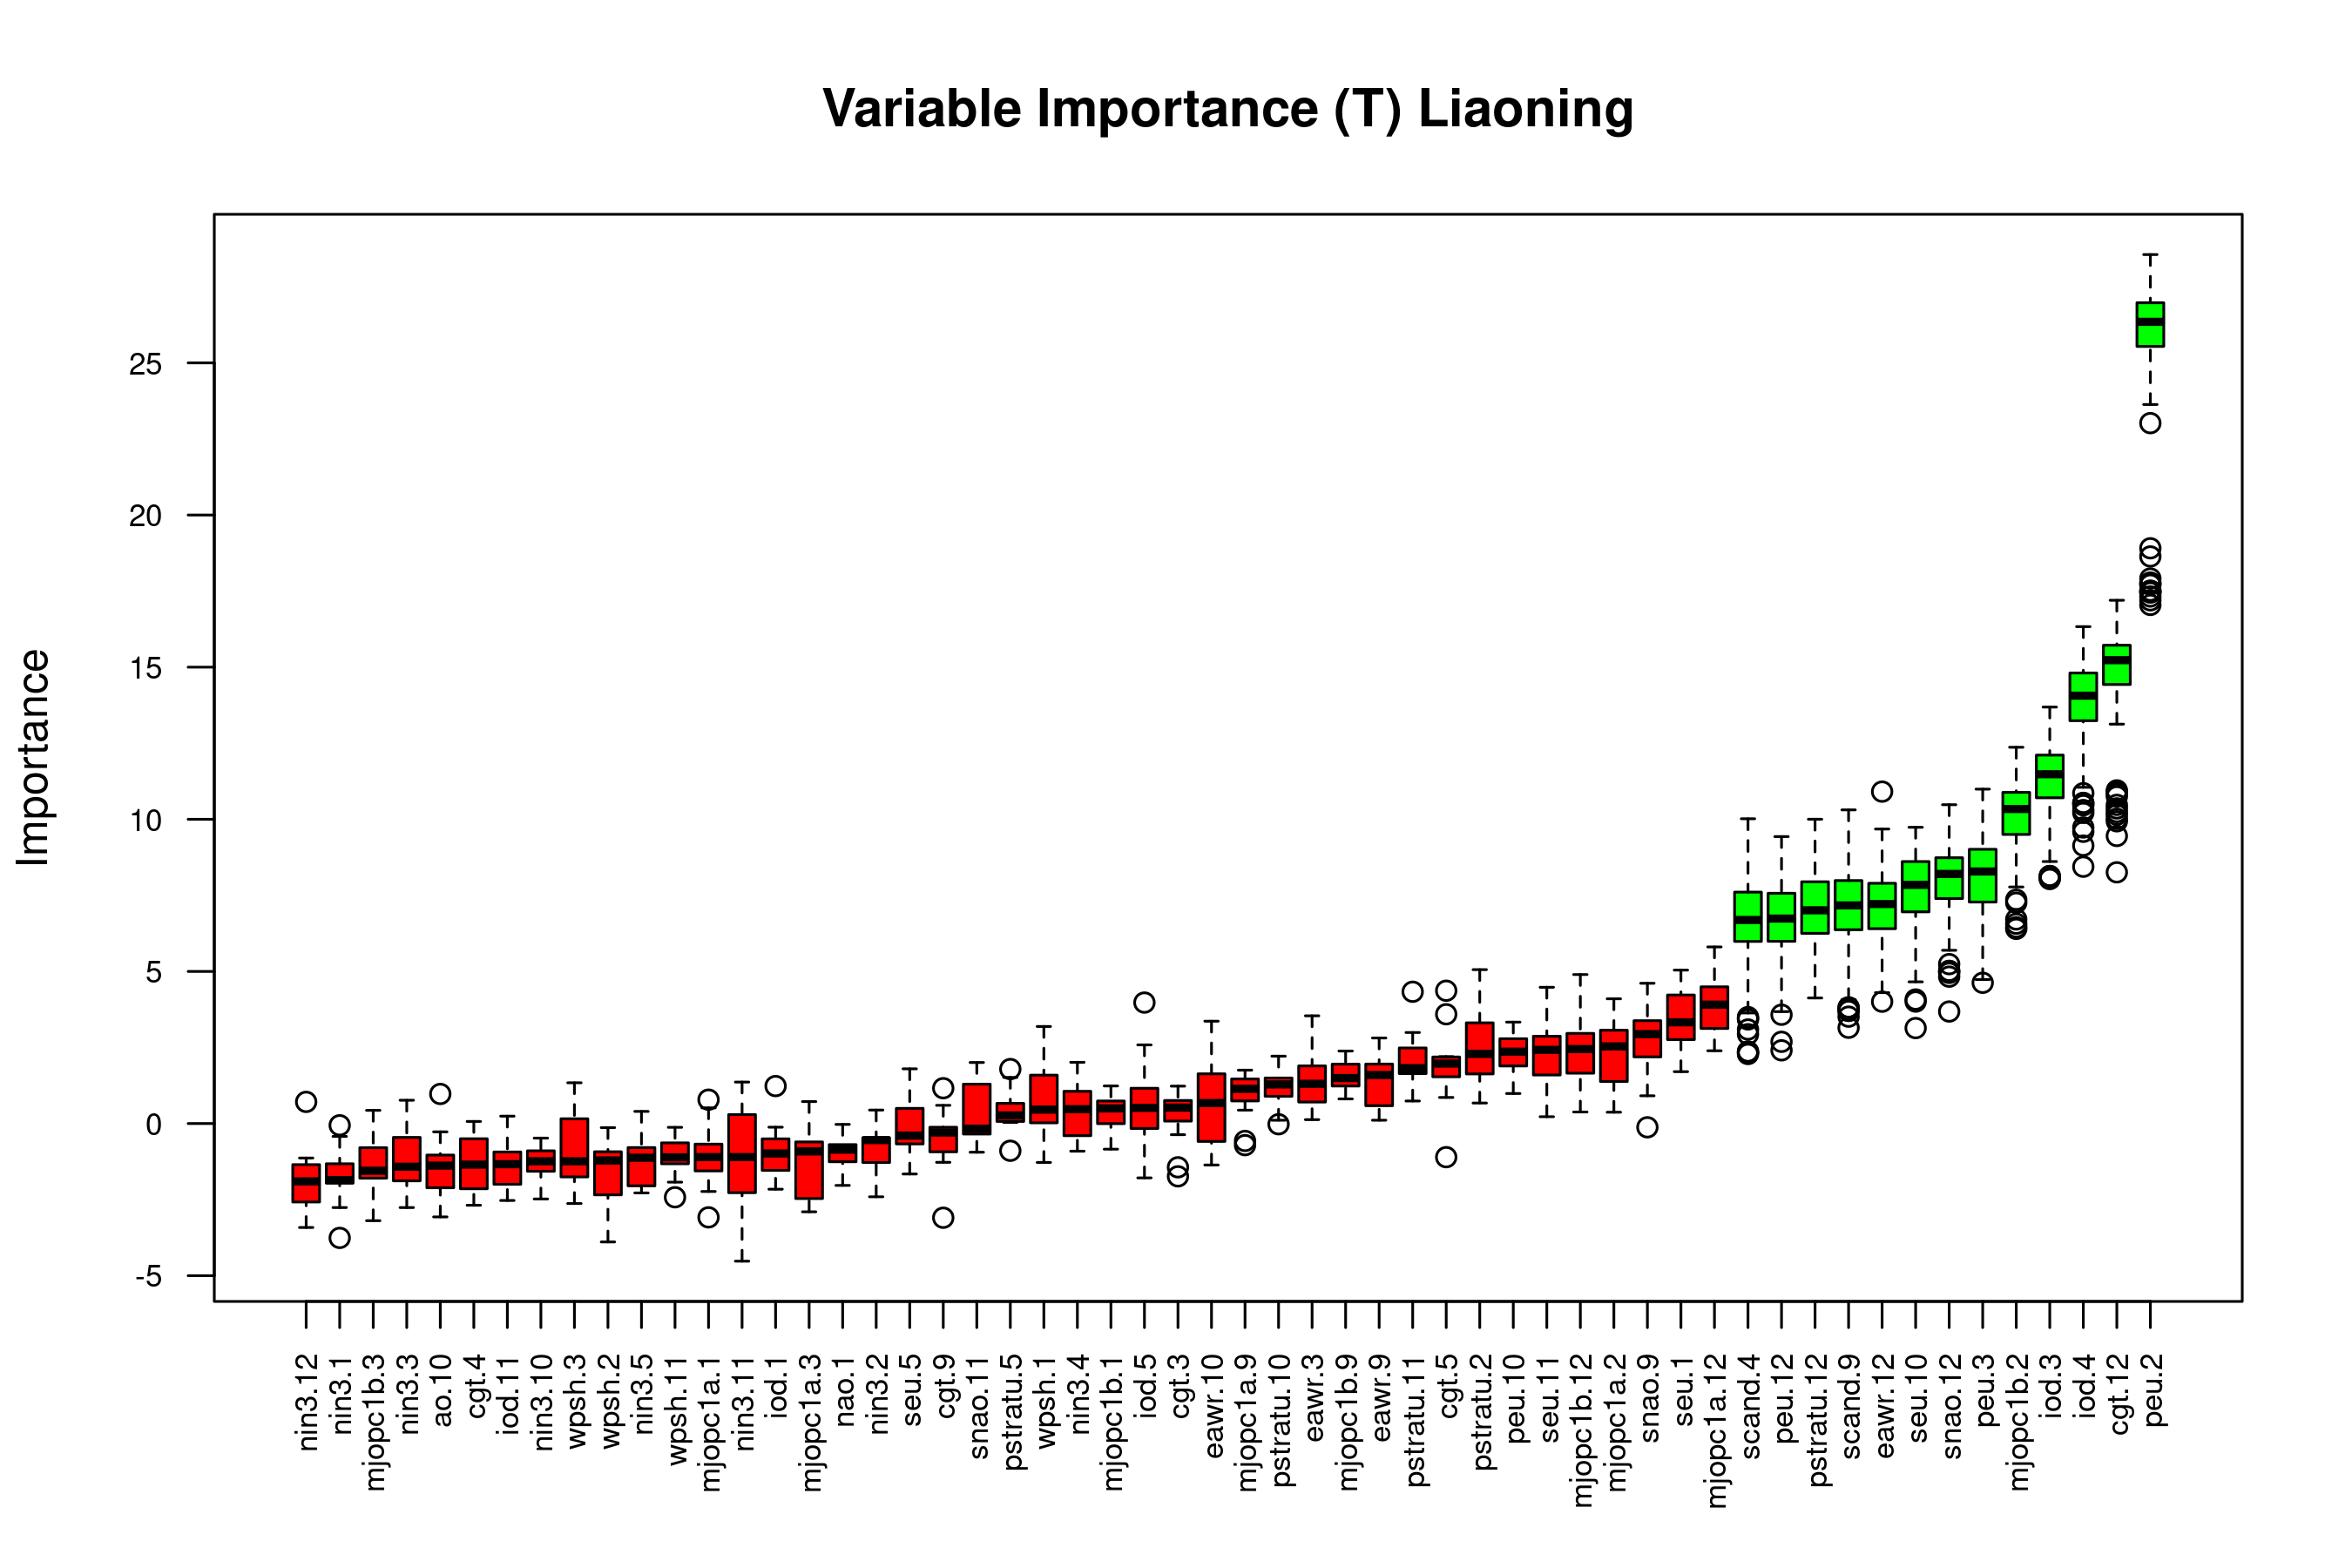

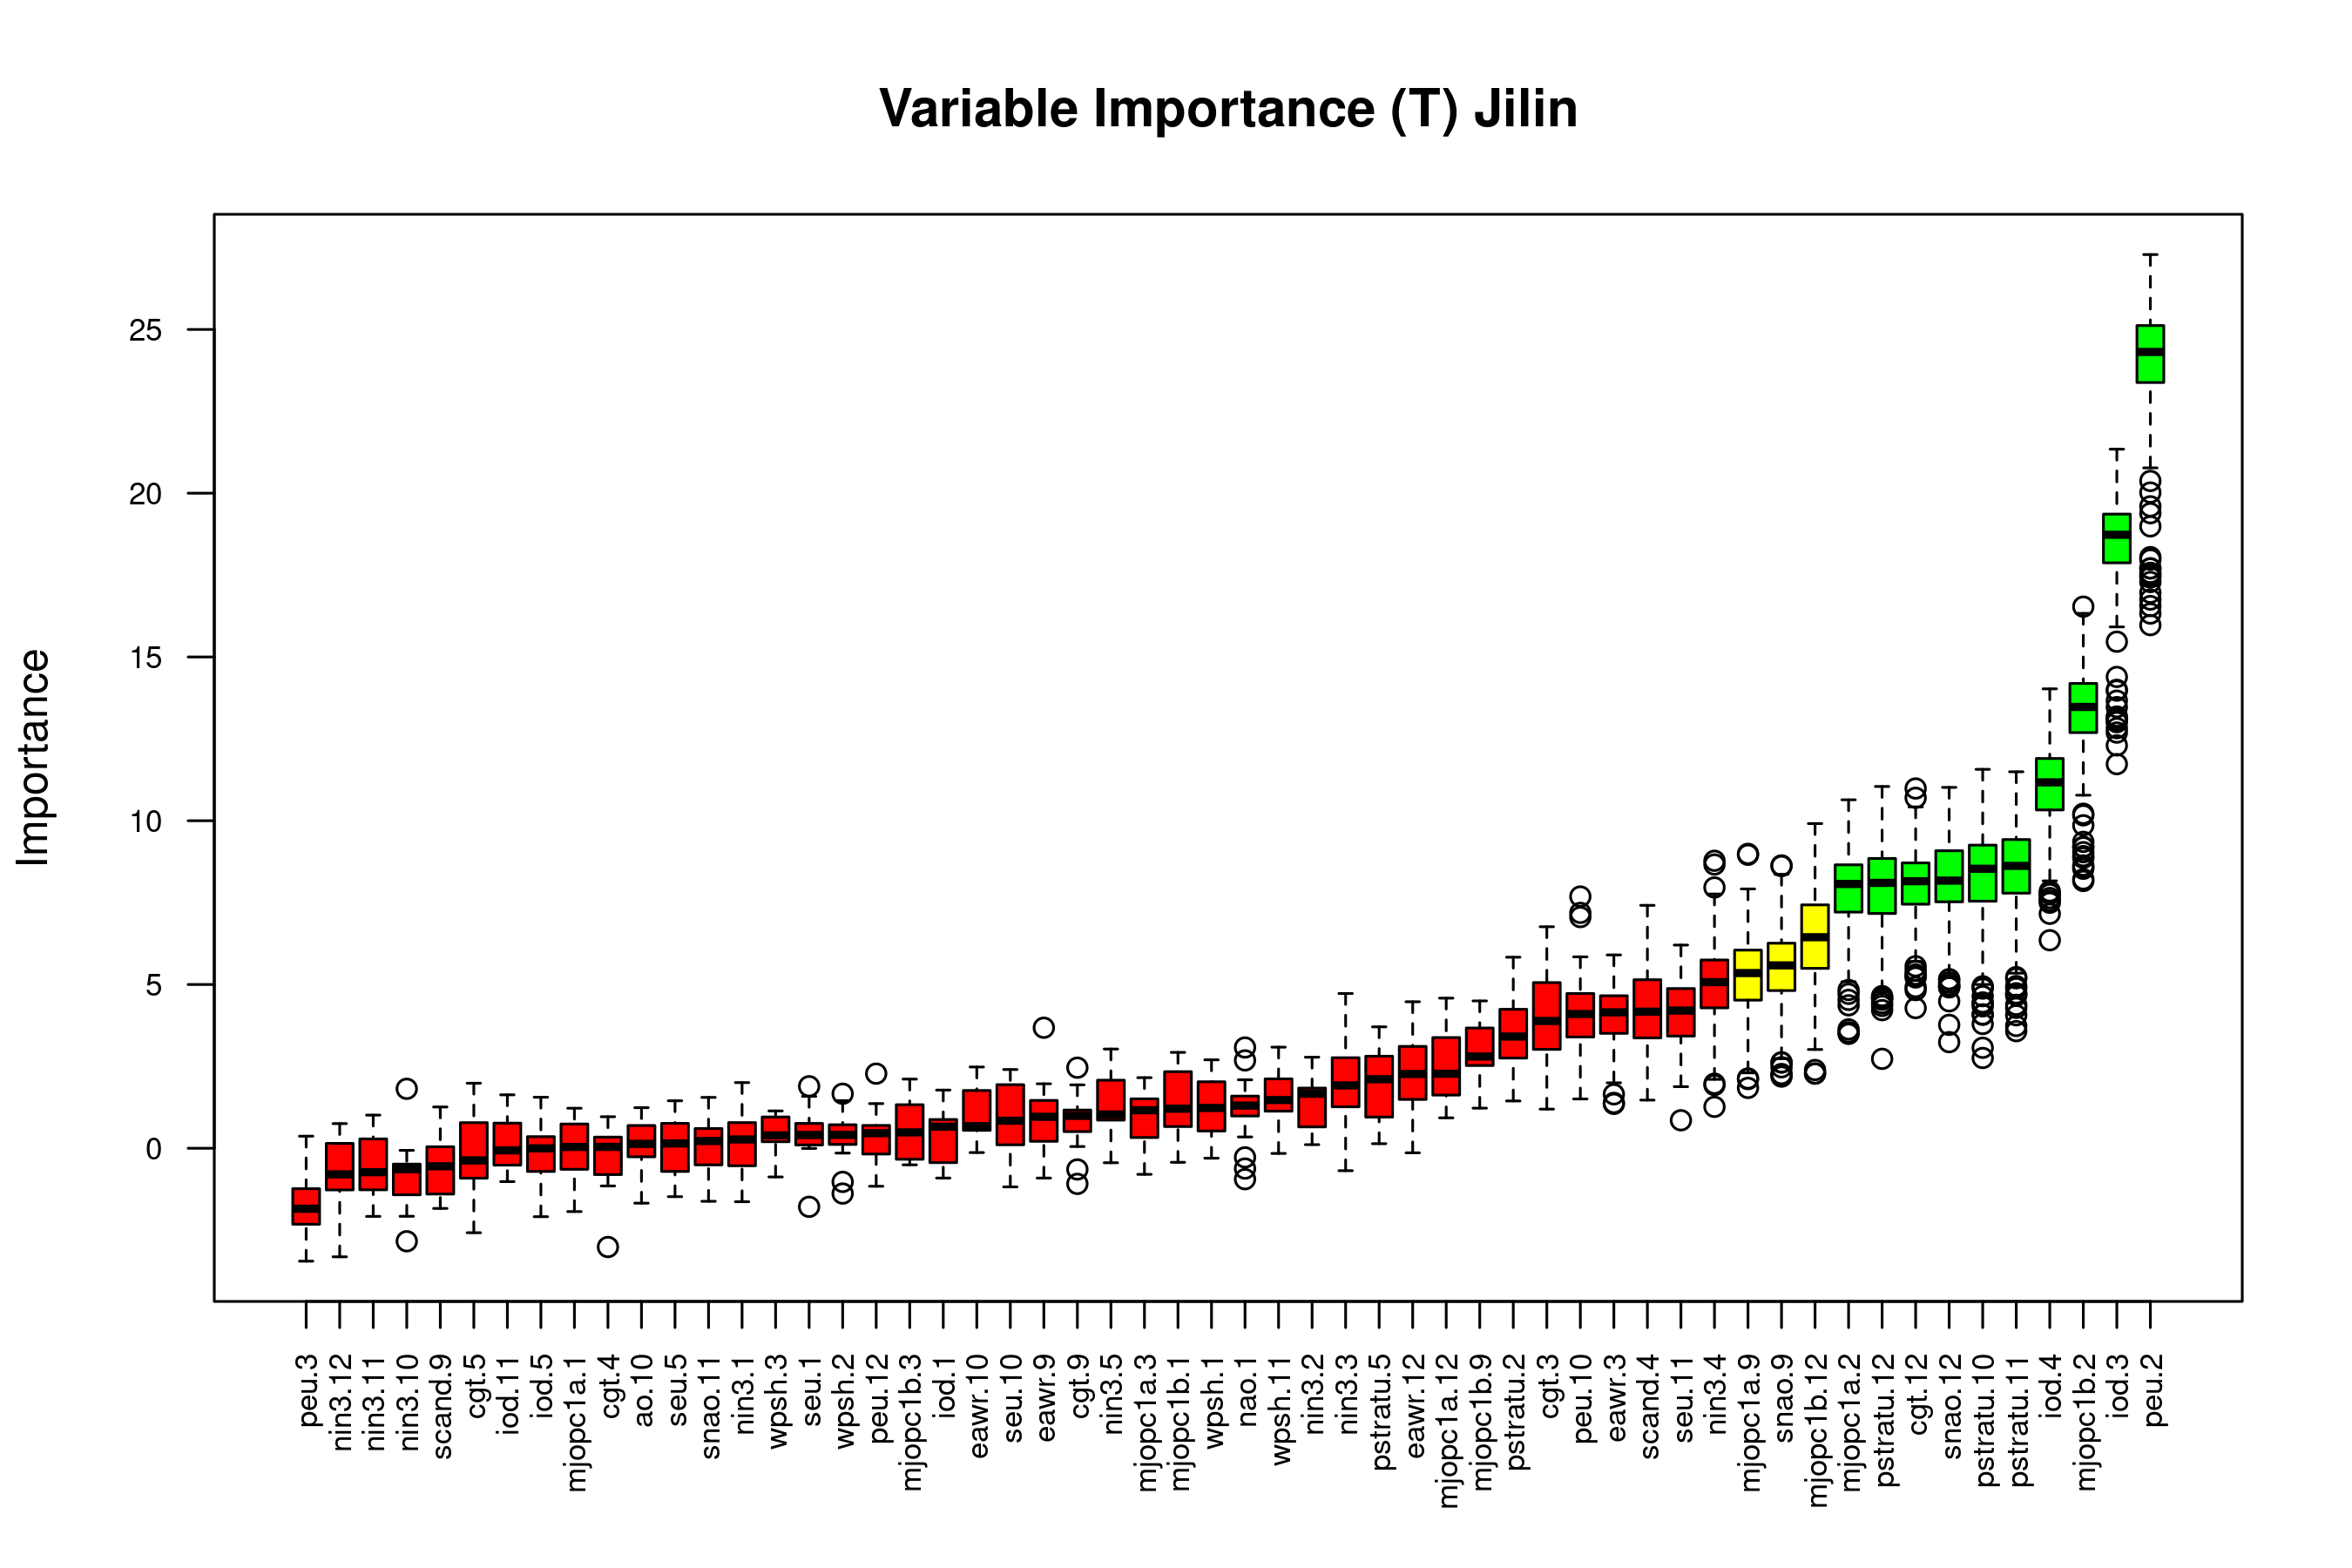

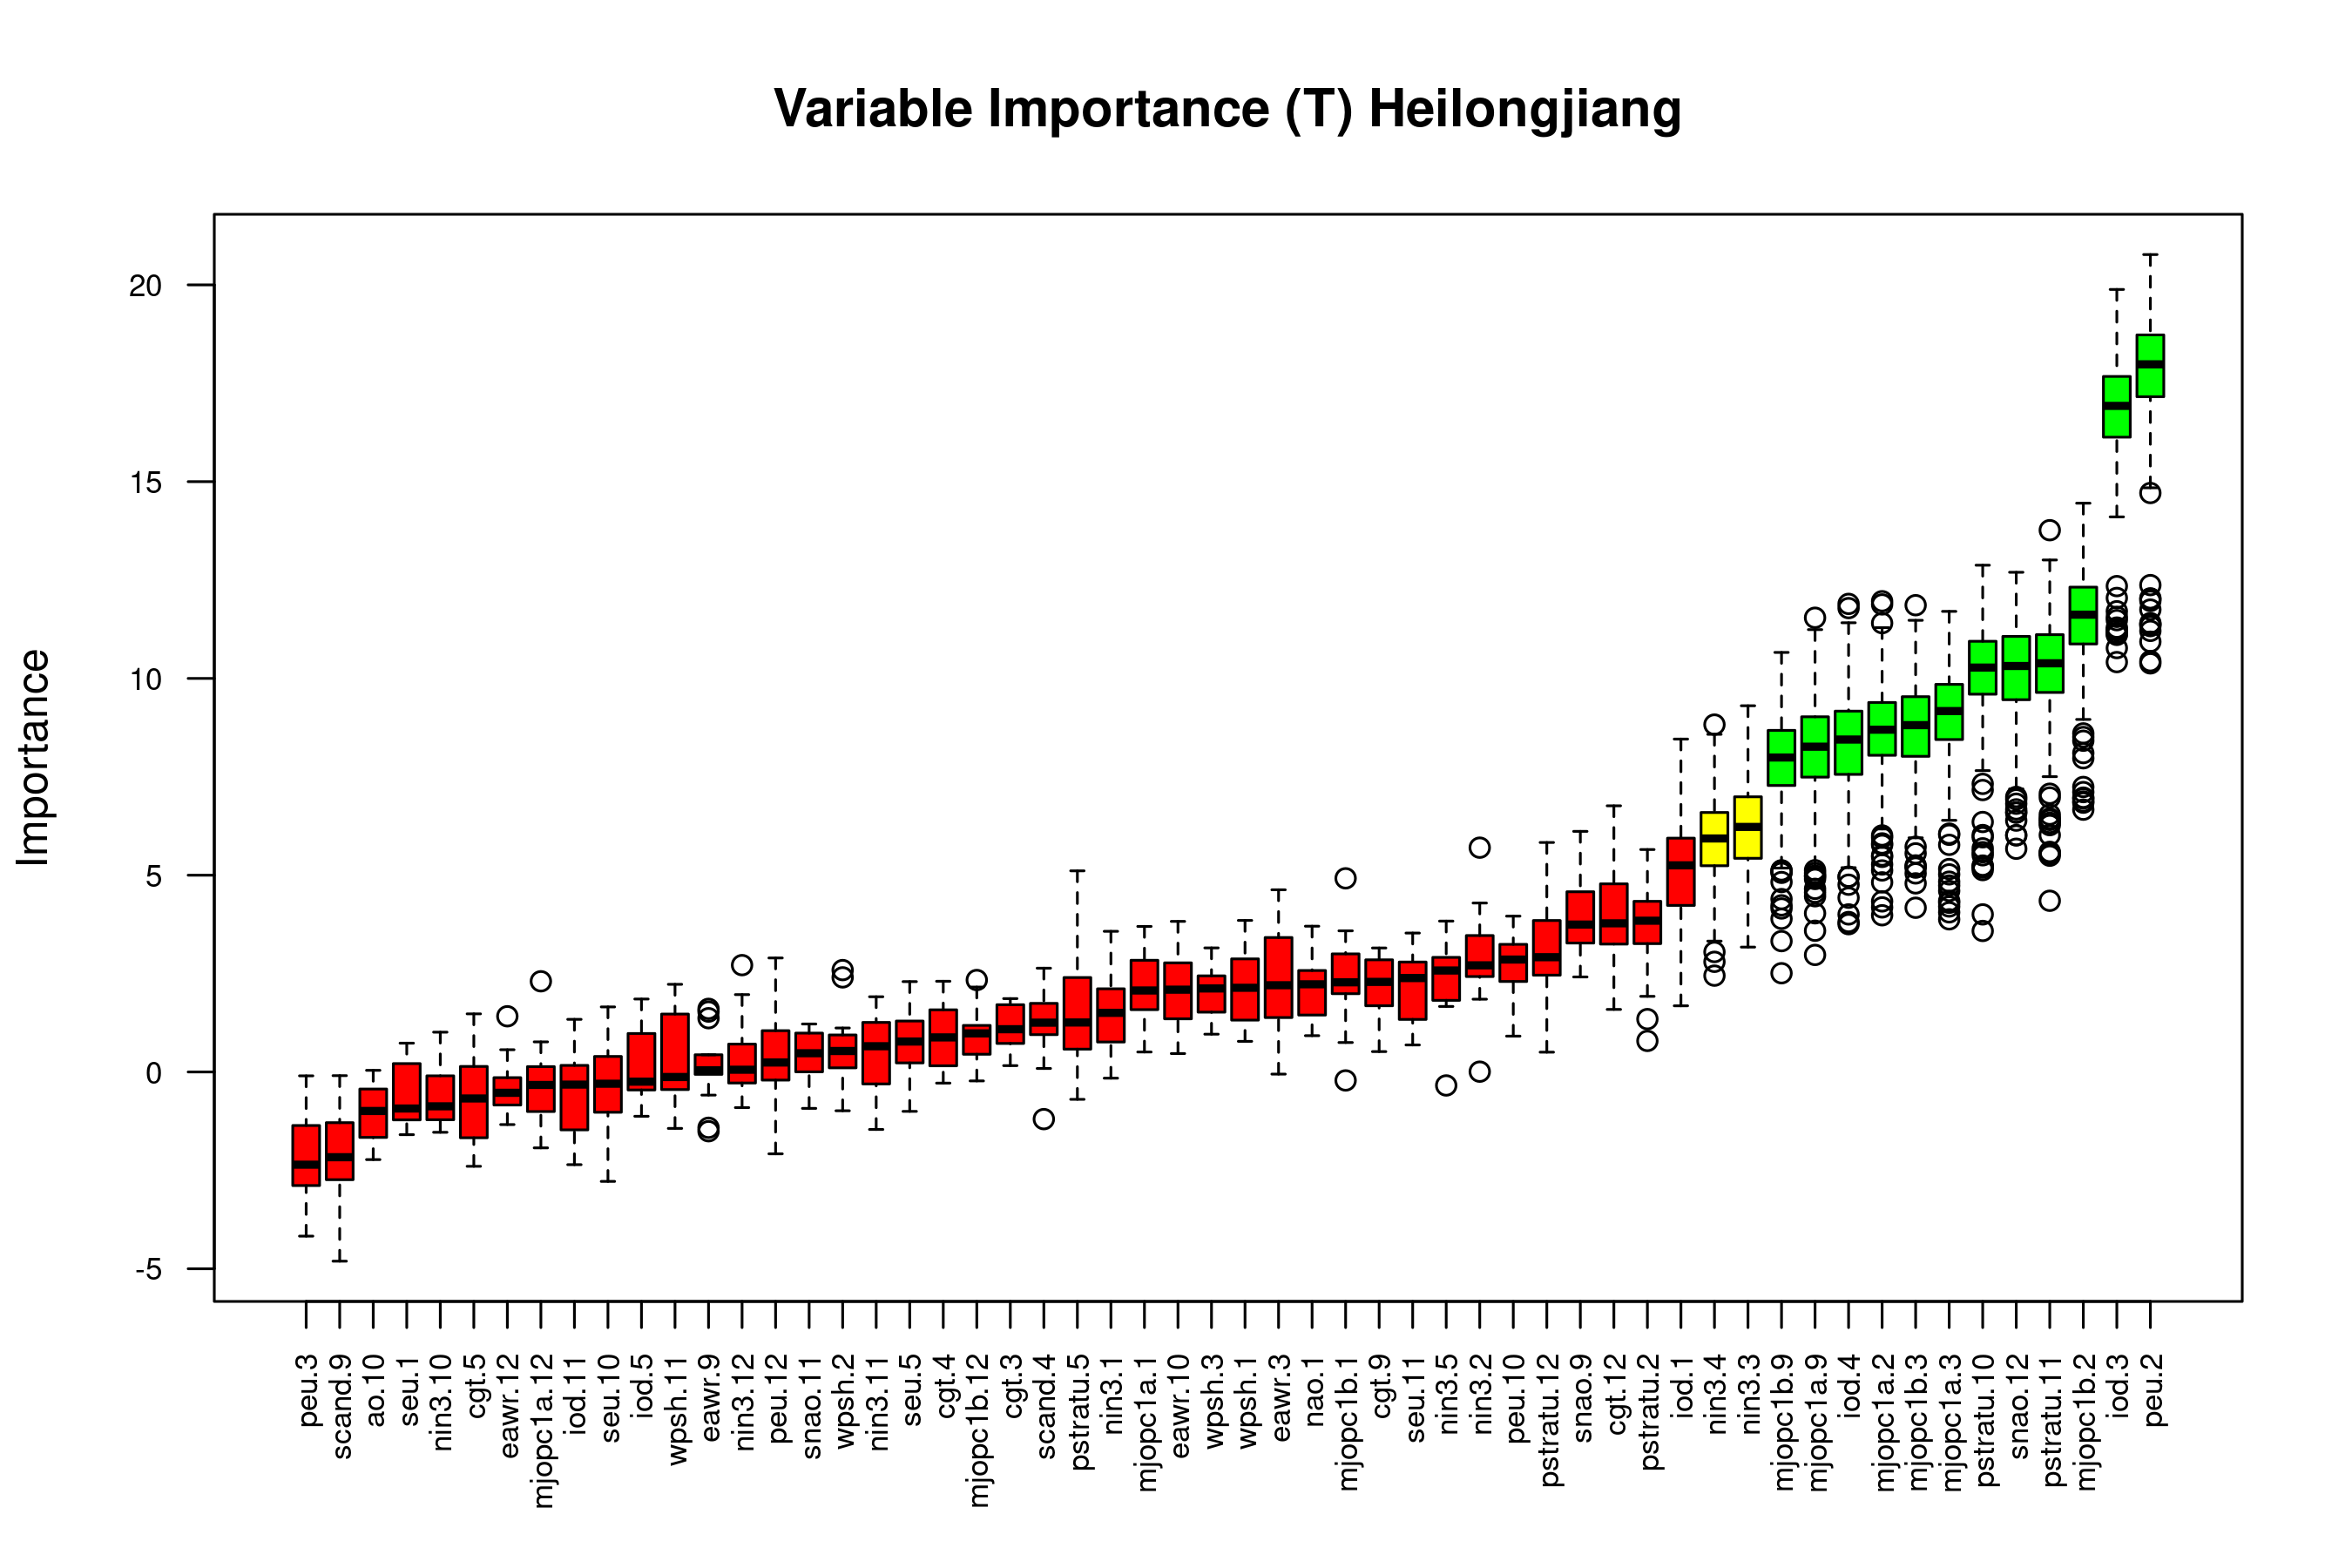

In [23]:
for (k in 1:length(regs)) {
    fname = paste('./',region,'_varimp_',regs[k],'_',ystrts,'_',yends,"_lag_",lag,'_',suffix,'.png', sep="")
    png(fname,width=9,height=6,units="in",res=300)
    plot(rf_results[[regs[k]]], cex.axis=.7, las=2, xlab="", main=paste("Variable Importance (T)", regs[k]), whichShadow = c(FALSE, FALSE, FALSE))  # plot variable  
    dev.off()
    display_png(file=fname, width=750)
    }

### Top 10 strongest predictors for temperature in each region
Make a barplot of the top ten predictors for each region, with their correlation coefficients

In [24]:
top10_correlations_df <- function(ind, k) {
    c_inds = order(-abs(ind[,k]))[1:10]
    c_names = row.names(ind)[order(-abs(ind[,1]))][1:10]
    c_df = data.frame(feature = c_names, importance = abs(ind[c_inds,k]))
    return(c_df)
}

In [25]:
plot_10_correlations <- function( df, region_name, filename) {
    ggplot(data = df) + 
    aes(x = reorder(feature, -importance), y = importance, fill = feature) +
    geom_bar(stat="identity") + 
    labs(x = "Features", y = "Correlation") +
    geom_text(aes(label = round(importance, 2)), vjust=1.6, color="white", size=4) + 
    theme_bw() + 
    theme(legend.position = "none") + 
    ggtitle(paste('Feature correlated with T', region_name))
    ggsave(filename, width=6, height=4)
}

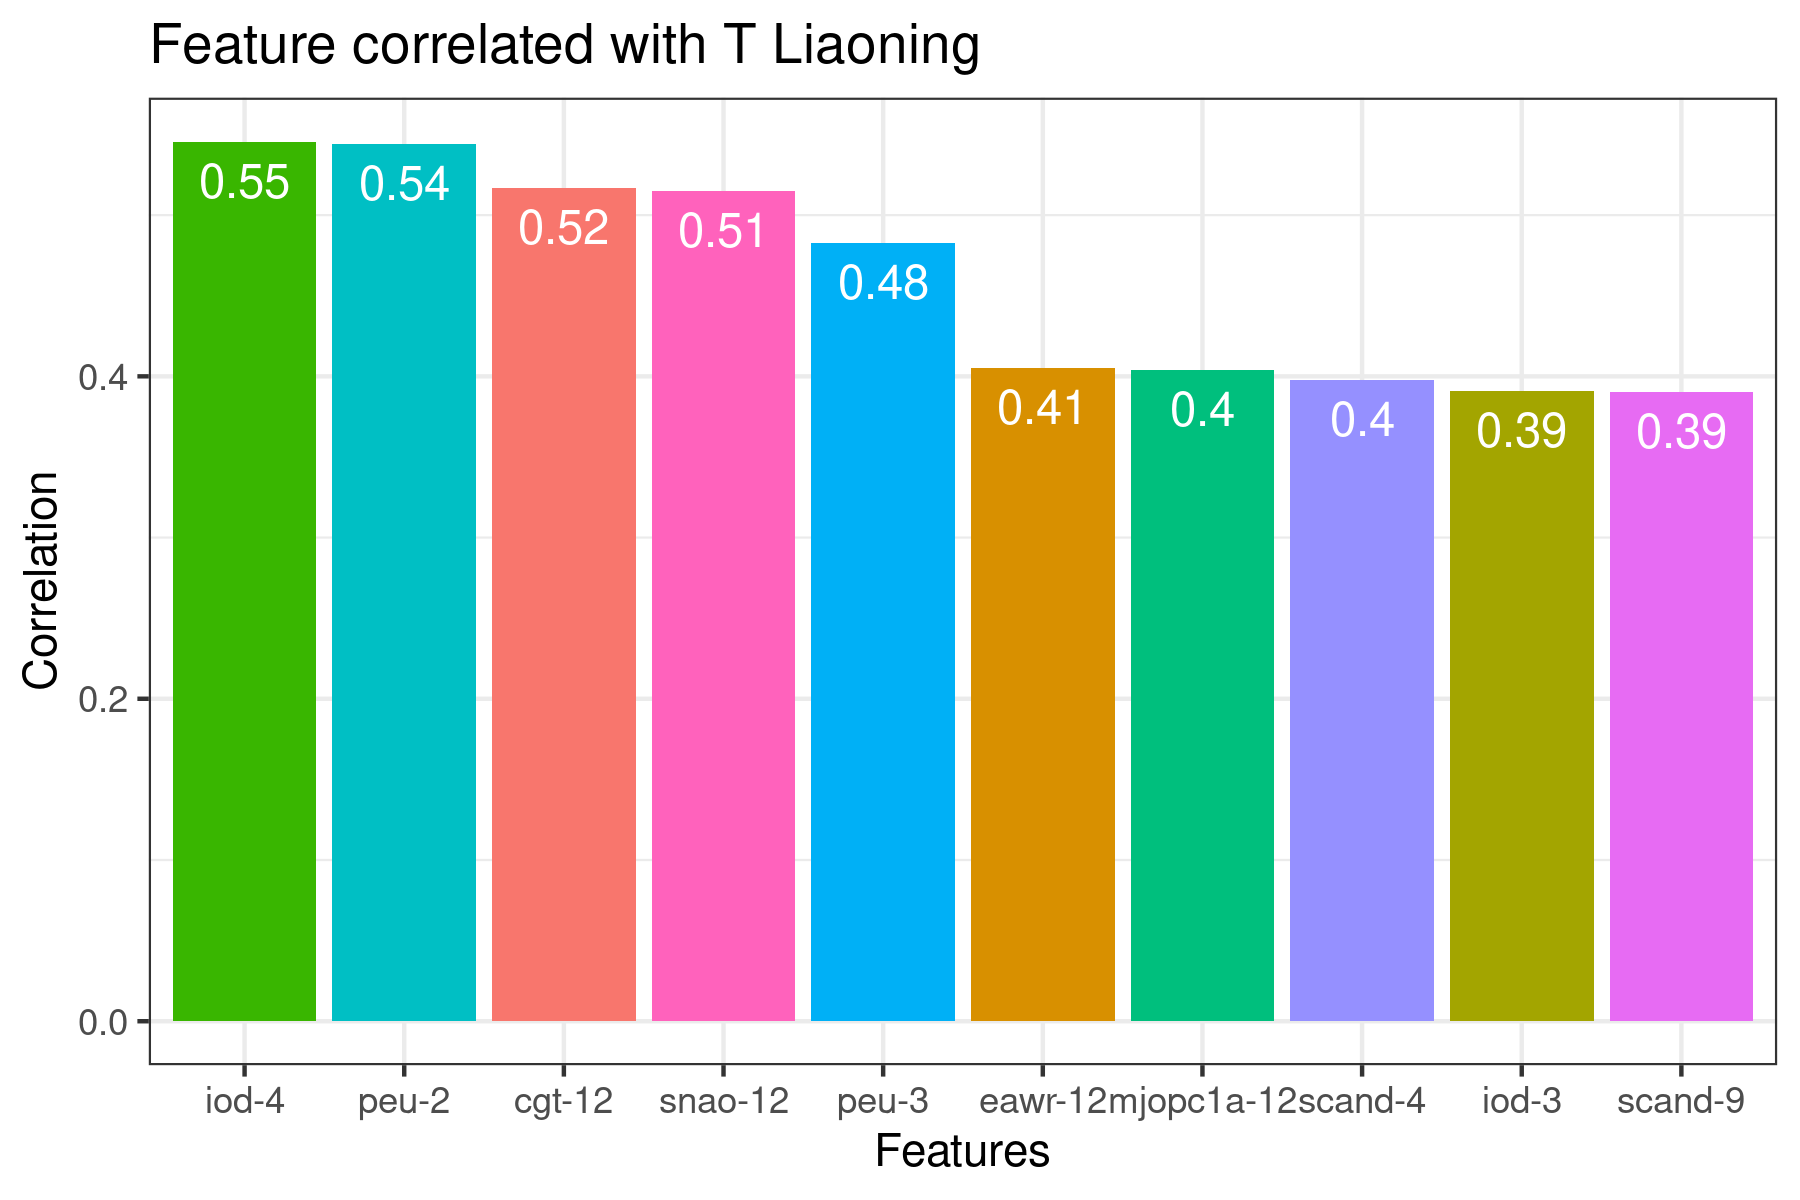

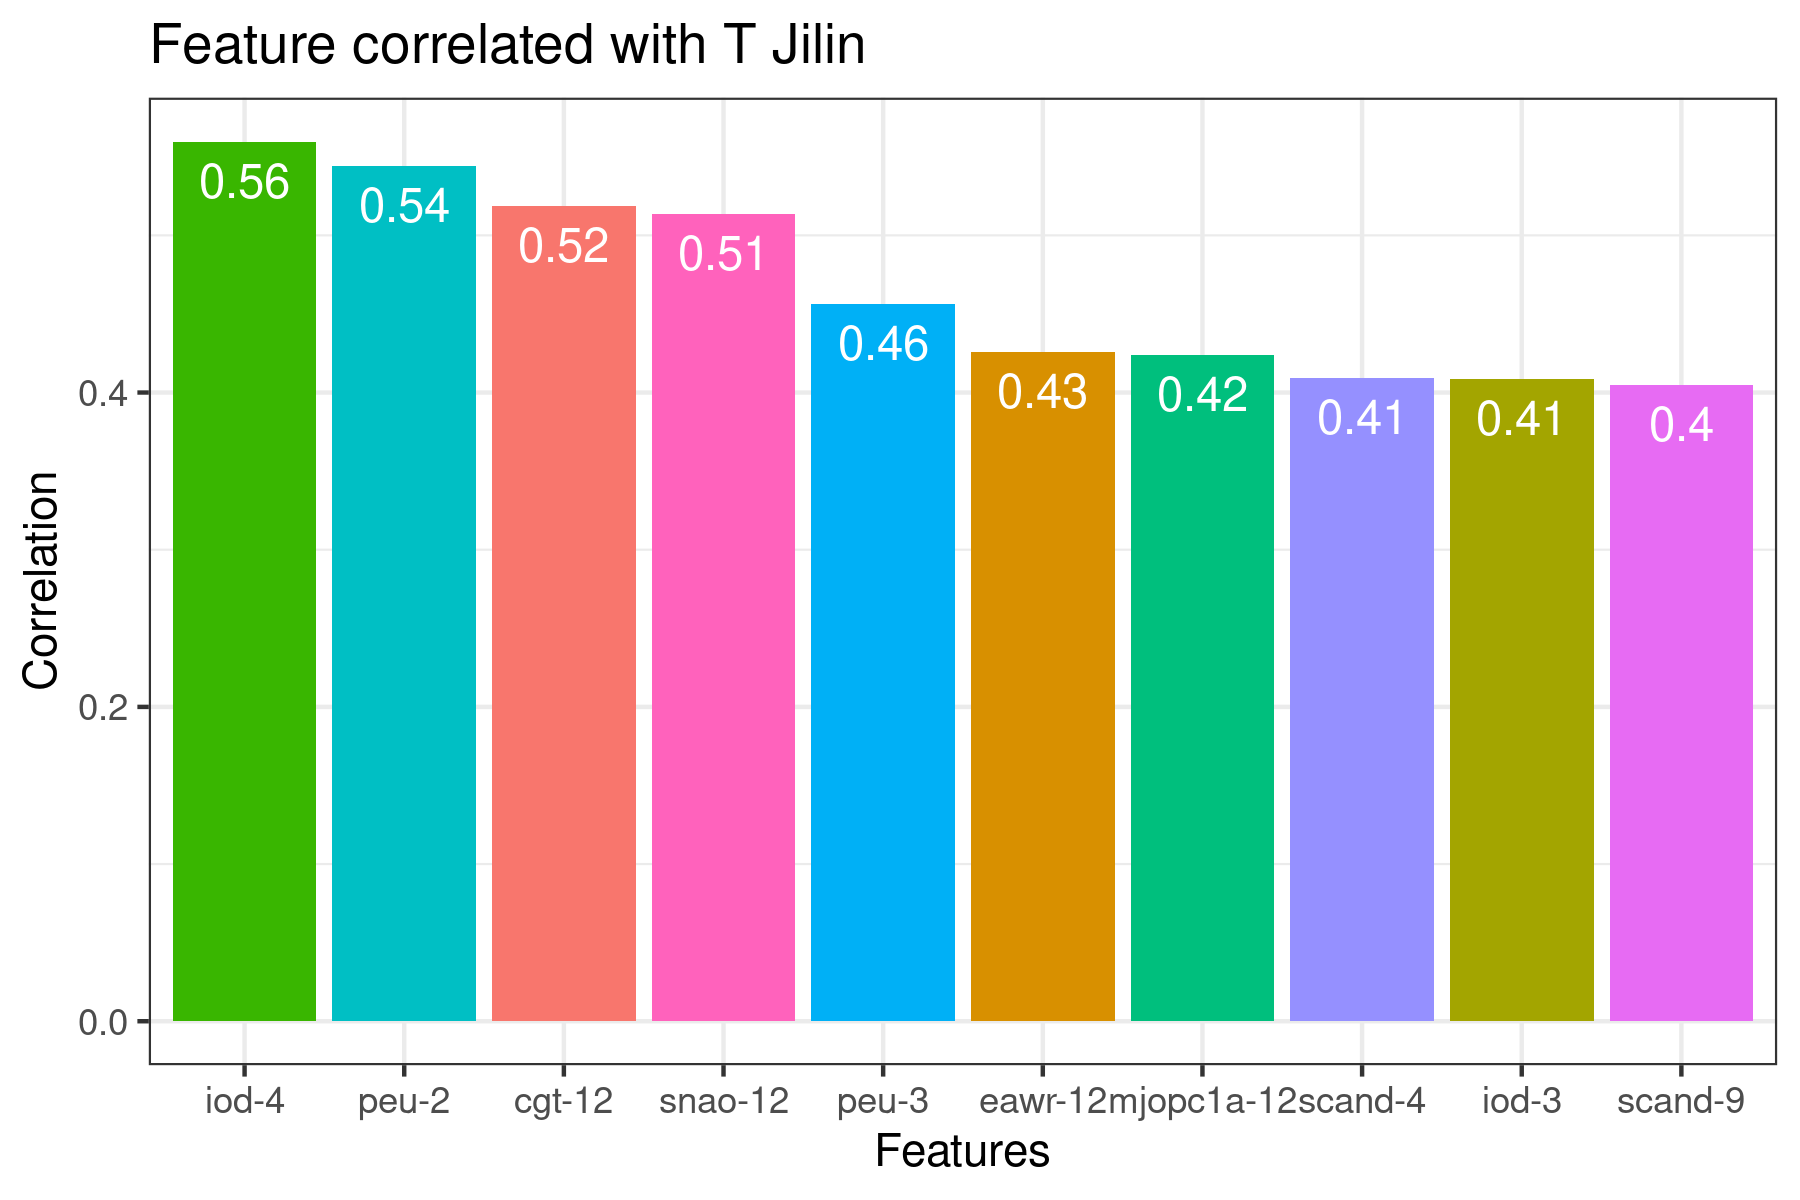

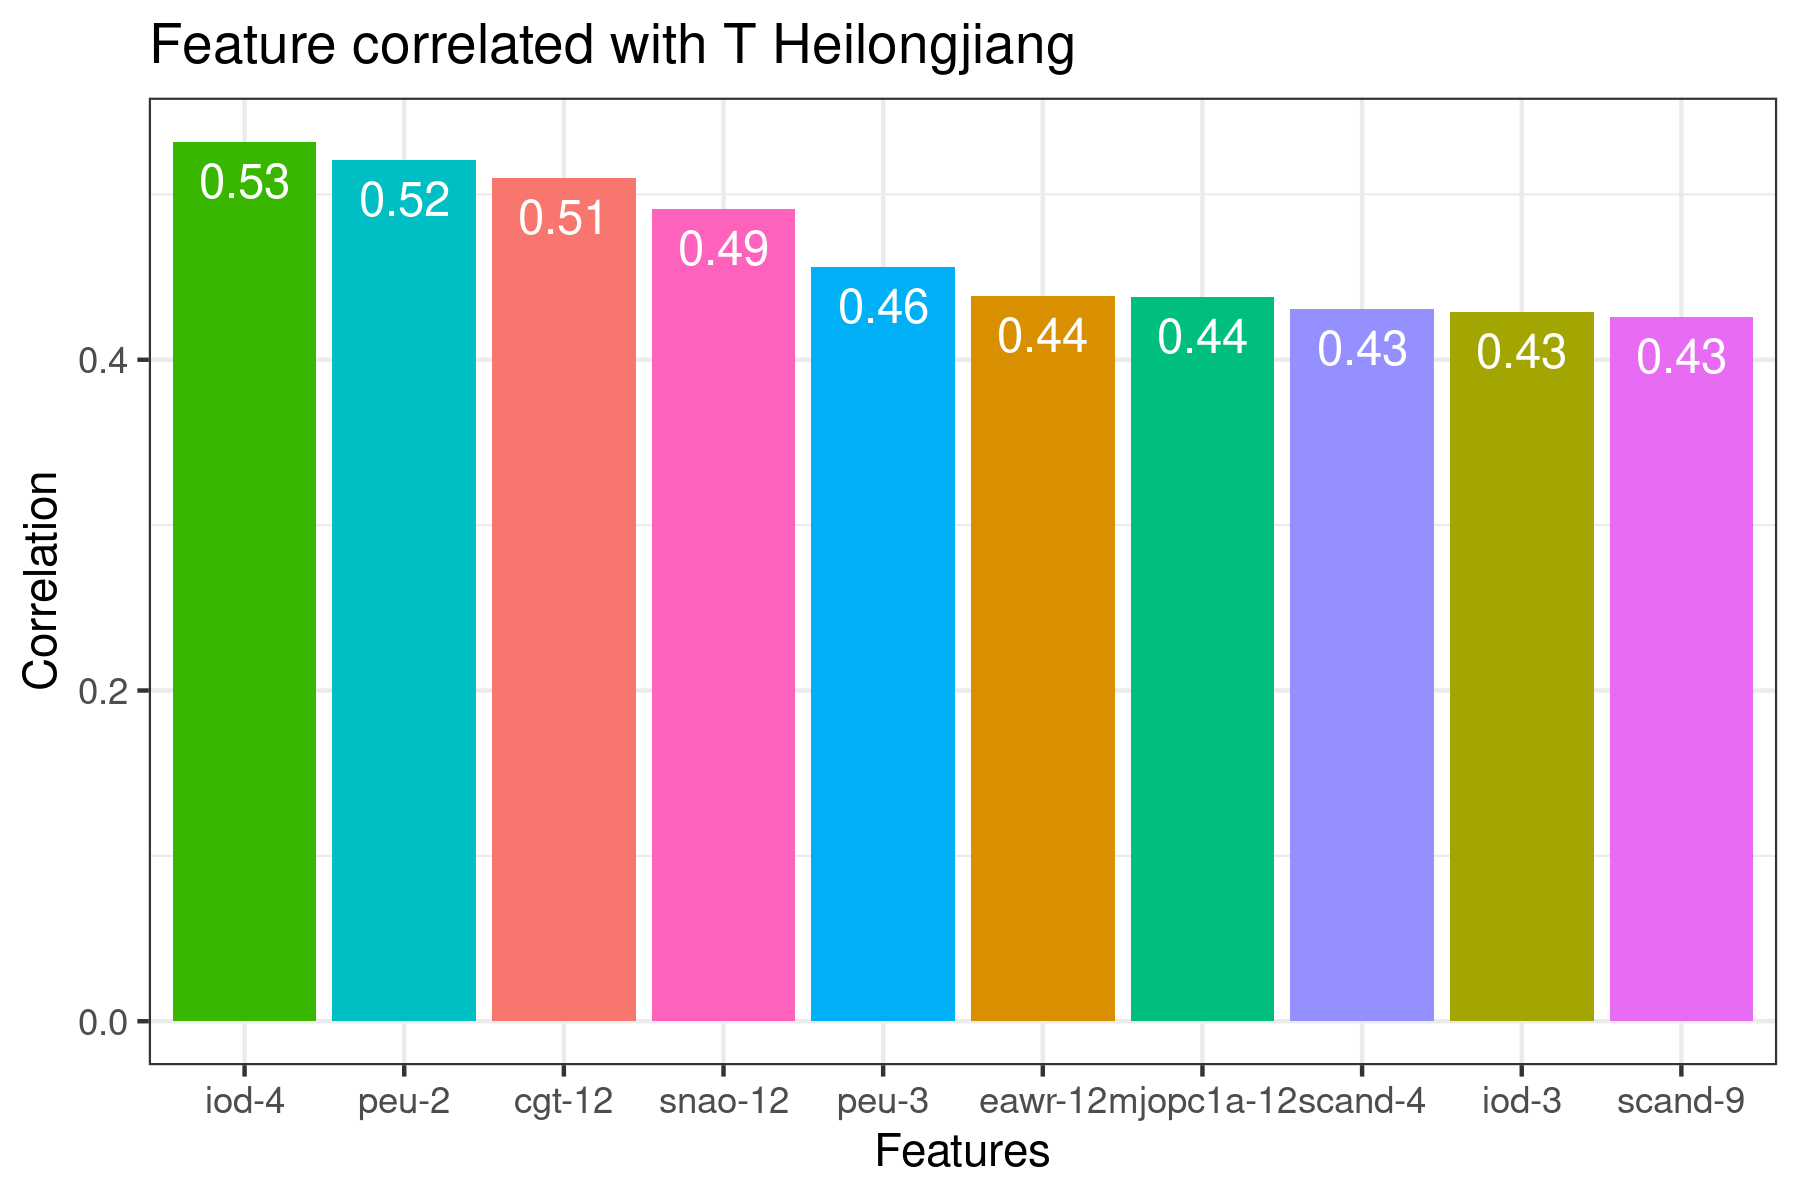

In [26]:
for (k in 1:length(regs)) {
    fname = paste("./", region, "_corimp_temp_", regs[k],".png", sep="") # filename to save figure to     
    t10_df = top10_correlations_df(cindex_temp_cors, k) # create dataframe of top 10 correlations 
    plot_10_correlations(t10_df, regs[k] ,fname) # plot em 
    display_png(file=fname, width=750) # display the figure in the notebook
    }

### Selected predictors for each region
Generate a plot to display the predictors determined to be significant for each province. 
This allows us to check which predictors are good for predicting temperature across the whole NFR region.

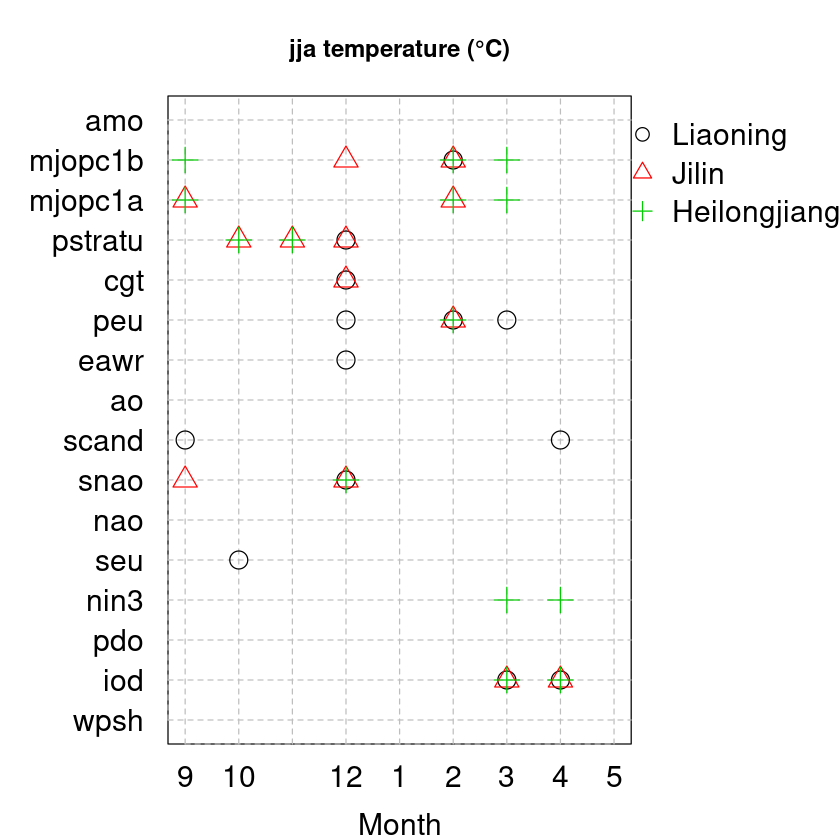

In [27]:
par(mfrow=c(1,1))
par(mar=c(4,7,4,8.7))
plot(NULL, xlim=c(1,length(mon_list)), ylim=c(1,length(ind_list)), ylab="", xlab="Month", 
     main = paste(suffix," temperature (\u00B0C)",sep=""), xaxt="n", yaxt="n", cex.lab=1.5)
axis(1, at=1:length(mon_list), labels=mon_list,cex.axis=1.0, tck = 1, lty = 2, col = "grey", 
     cex.lab=1.5, cex.axis=1.5)
axis(2, at=1:length(ind_list), labels=ind_list,cex.axis=1.0, tck = 1, lty = 2, col = "grey", 
     cex.lab=1.5, cex.axis=1.5, las=1)

sub = 2:(length(colnames(cindex_anoms)) + 1)

for (k in 1:1:length(regs)) {
    tinds = which(abs(coef_array_full[k,2,sub]) > 0.5)
    tnames = strsplit(names(tinds), split = "-")
    var_tind = numeric(0)
    mon_tind = numeric(0)
    
    for (i in 1:length(tinds)) {
    var_tind[i] = which(tnames[[i]][1] == ind_list)
    mon_tind[i] = which(as.numeric(tnames[[i]][2]) == mon_list)
    }
    
    points(mon_tind, var_tind, pch=k, col=k, cex=2)
}

legend("topright", legend = regs,bty = "n",
       pch = 1:length(regs), col=1:length(regs), 
       cex=1.5,xpd = TRUE, inset = c(-0.51, 0))

### Feature selection of East Asian subtropical and polar jets
Run the same feature importance analysis for the u- and v-wind jet indices.

In [28]:
x_train = jet_anoms
rf_jet_results = list()

dx2 = 1+dim(jet_anoms)[2]
coef_jarray_full = array(0, c(length(regs),4,dx2))
dimnames(coef_jarray_full)[[3]] <- c("Intercept", colnames(jet_anoms))
dimnames(coef_jarray_full)[[1]] <- regs

In [29]:
for (k in 1:length(regs)) {
    set.seed(1)
    y_train = temp_anoms[,k]
    df_in  = data.frame(cbind(x_train, y_train))
    boruta_output <- Boruta(y_train ~ ., data=df_in, doTrace=0, maxRuns= 200, ntree=2000, pValue = 0.1)  # perform Boruta search
    boruta_signif <- names(boruta_output$finalDecision[boruta_output$finalDecision %in% c("Confirmed", "Tentative")])  # collect Confirmed and Tentative variables
    tvars = gsub("[[:punct:]]", "-", boruta_signif)
    coef_jarray_full[k,2,tvars] = 1
    rf_jet_results[[regs[k]]] = boruta_output
}

In [30]:
rf_jet_results

$Liaoning
Boruta performed 60 iterations in 3.001869 secs.
 5 attributes confirmed important: eapju.6, eapju.8, easju.6, easju.7,
easju.8;
 19 attributes confirmed unimportant: eapju.3, eapju.4, eapju.5,
eapju.7, eapjv.3 and 14 more;

$Jilin
Boruta performed 187 iterations in 9.033612 secs.
 7 attributes confirmed important: eapju.6, eapju.8, eapjv.4, easju.6,
easju.7 and 2 more;
 17 attributes confirmed unimportant: eapju.3, eapju.4, eapju.5,
eapju.7, eapjv.3 and 12 more;

$Heilongjiang
Boruta performed 199 iterations in 10.25419 secs.
 6 attributes confirmed important: eapju.6, eapju.8, eapjv.5, easju.6,
easju.7 and 1 more;
 15 attributes confirmed unimportant: eapju.3, eapju.4, eapju.5,
eapju.7, eapjv.3 and 10 more;
 3 tentative attributes left: eapjv.4, easjv.4, easjv.5;


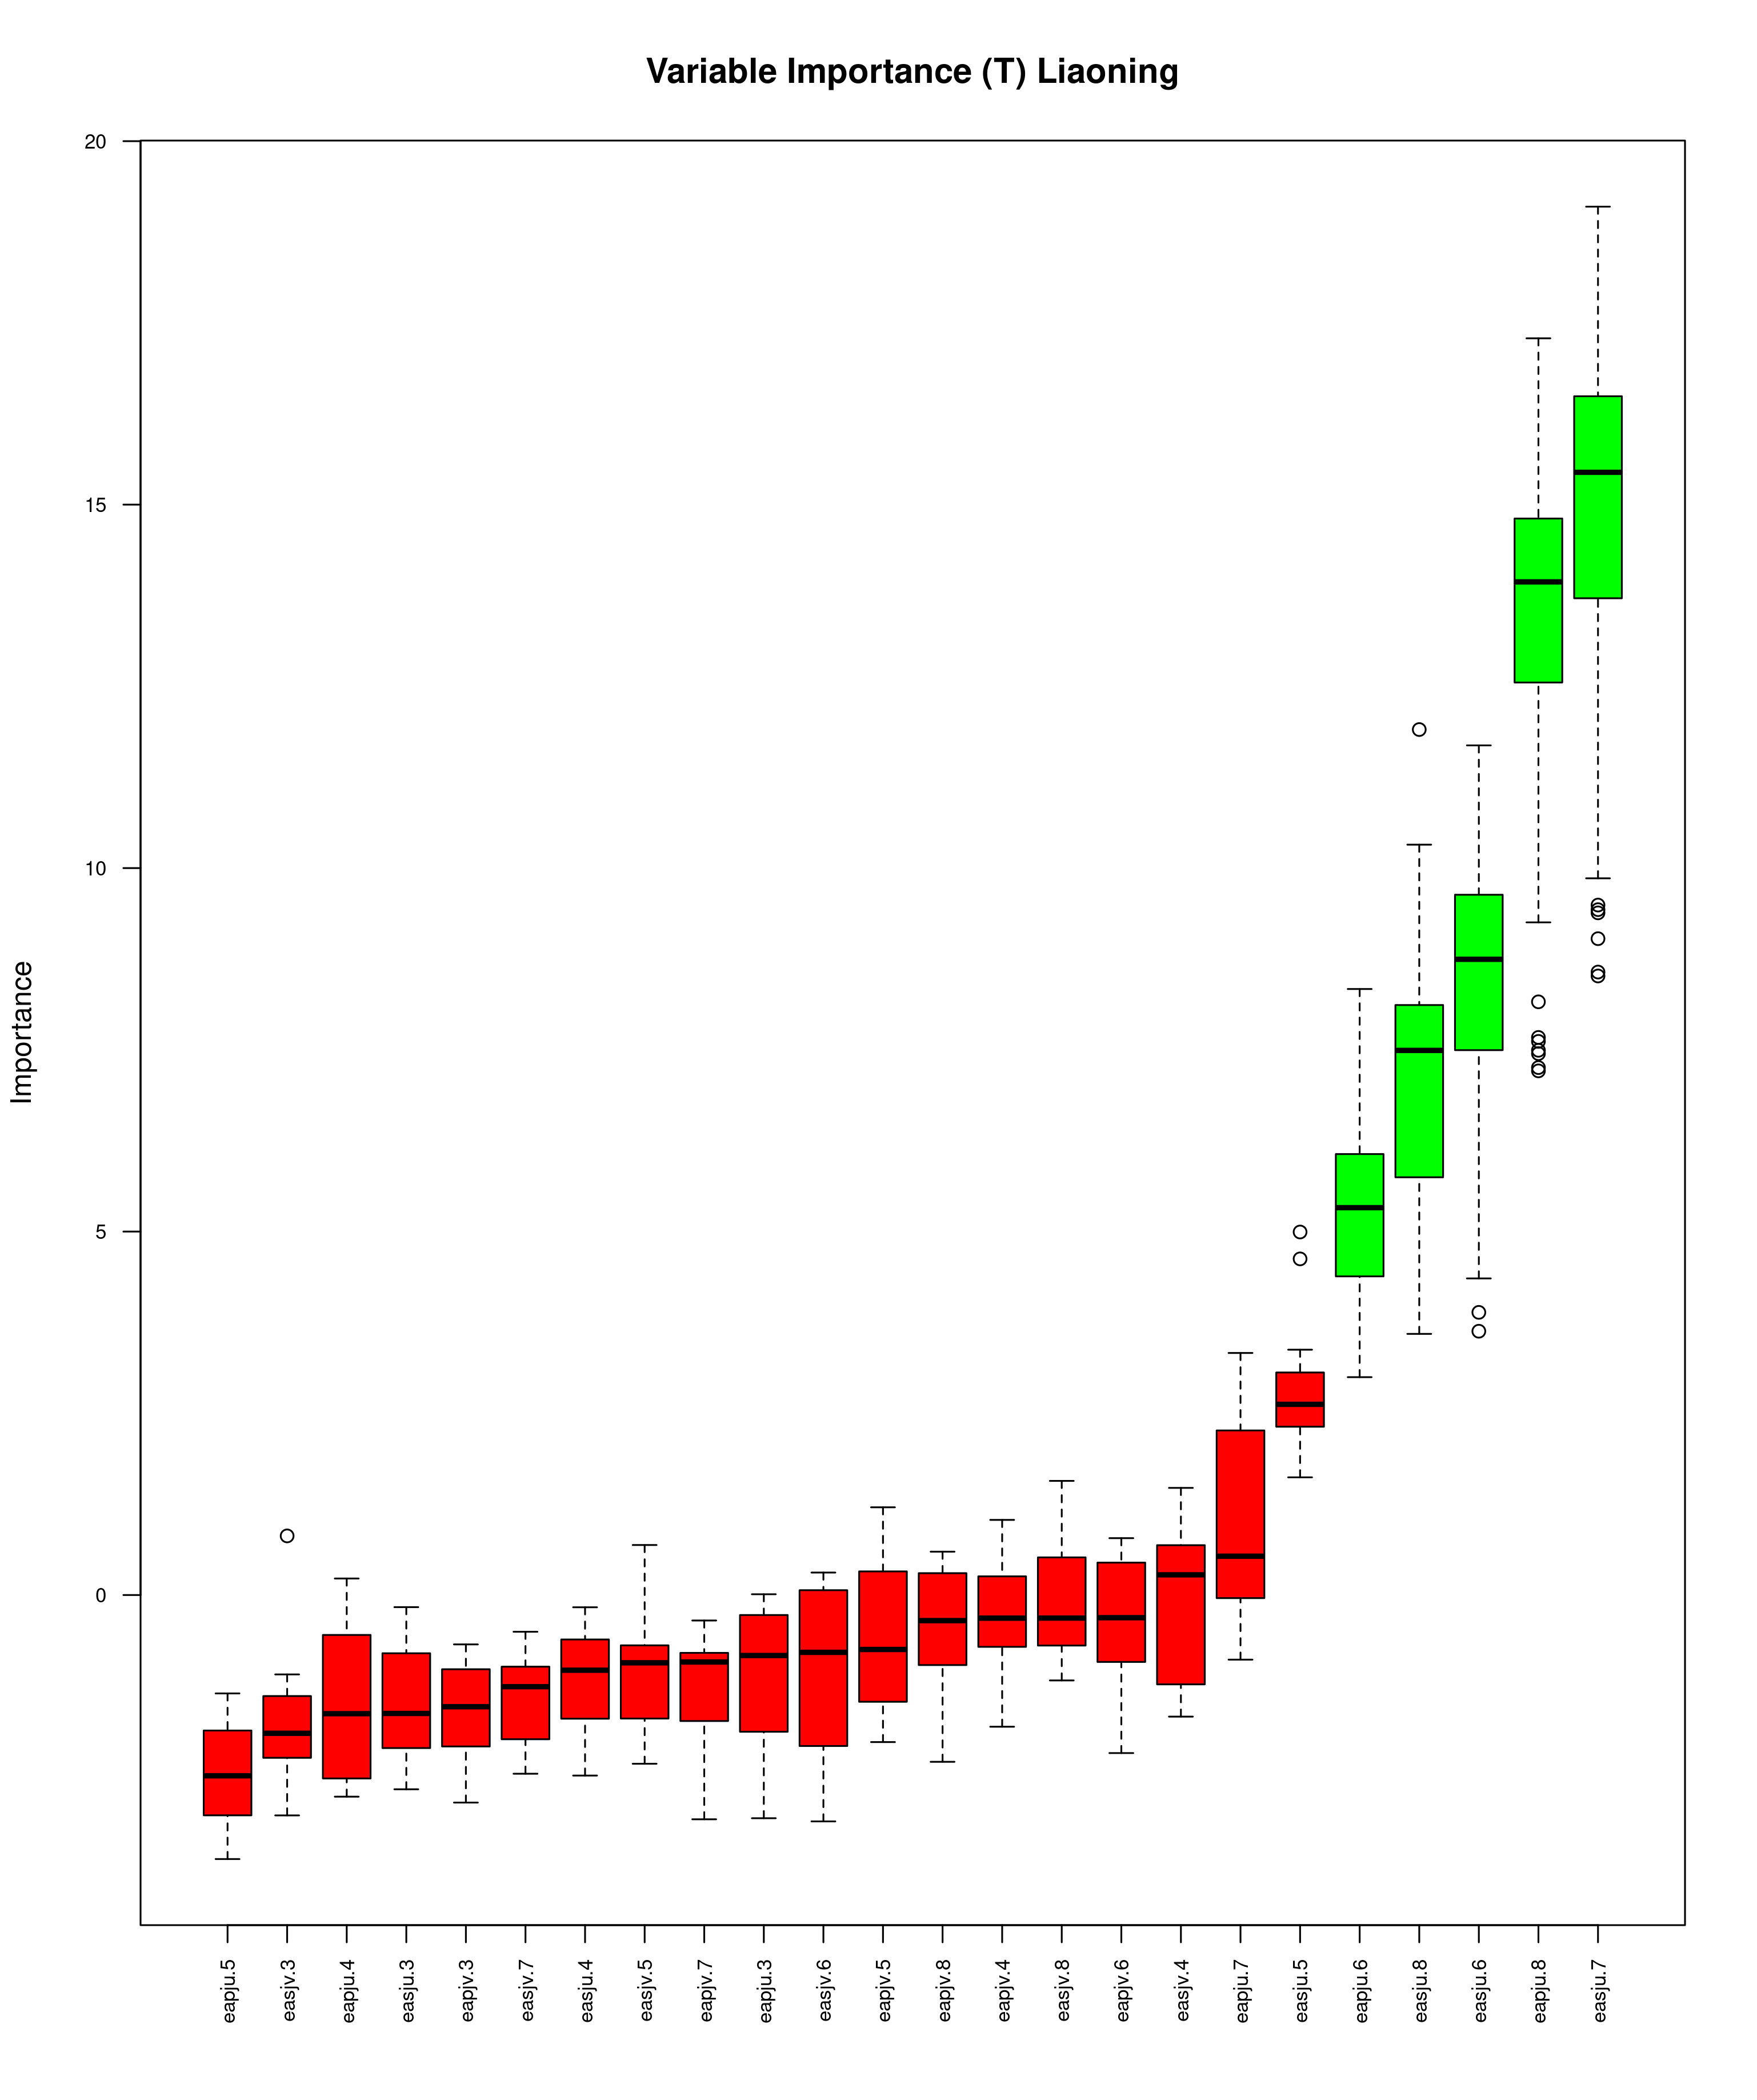

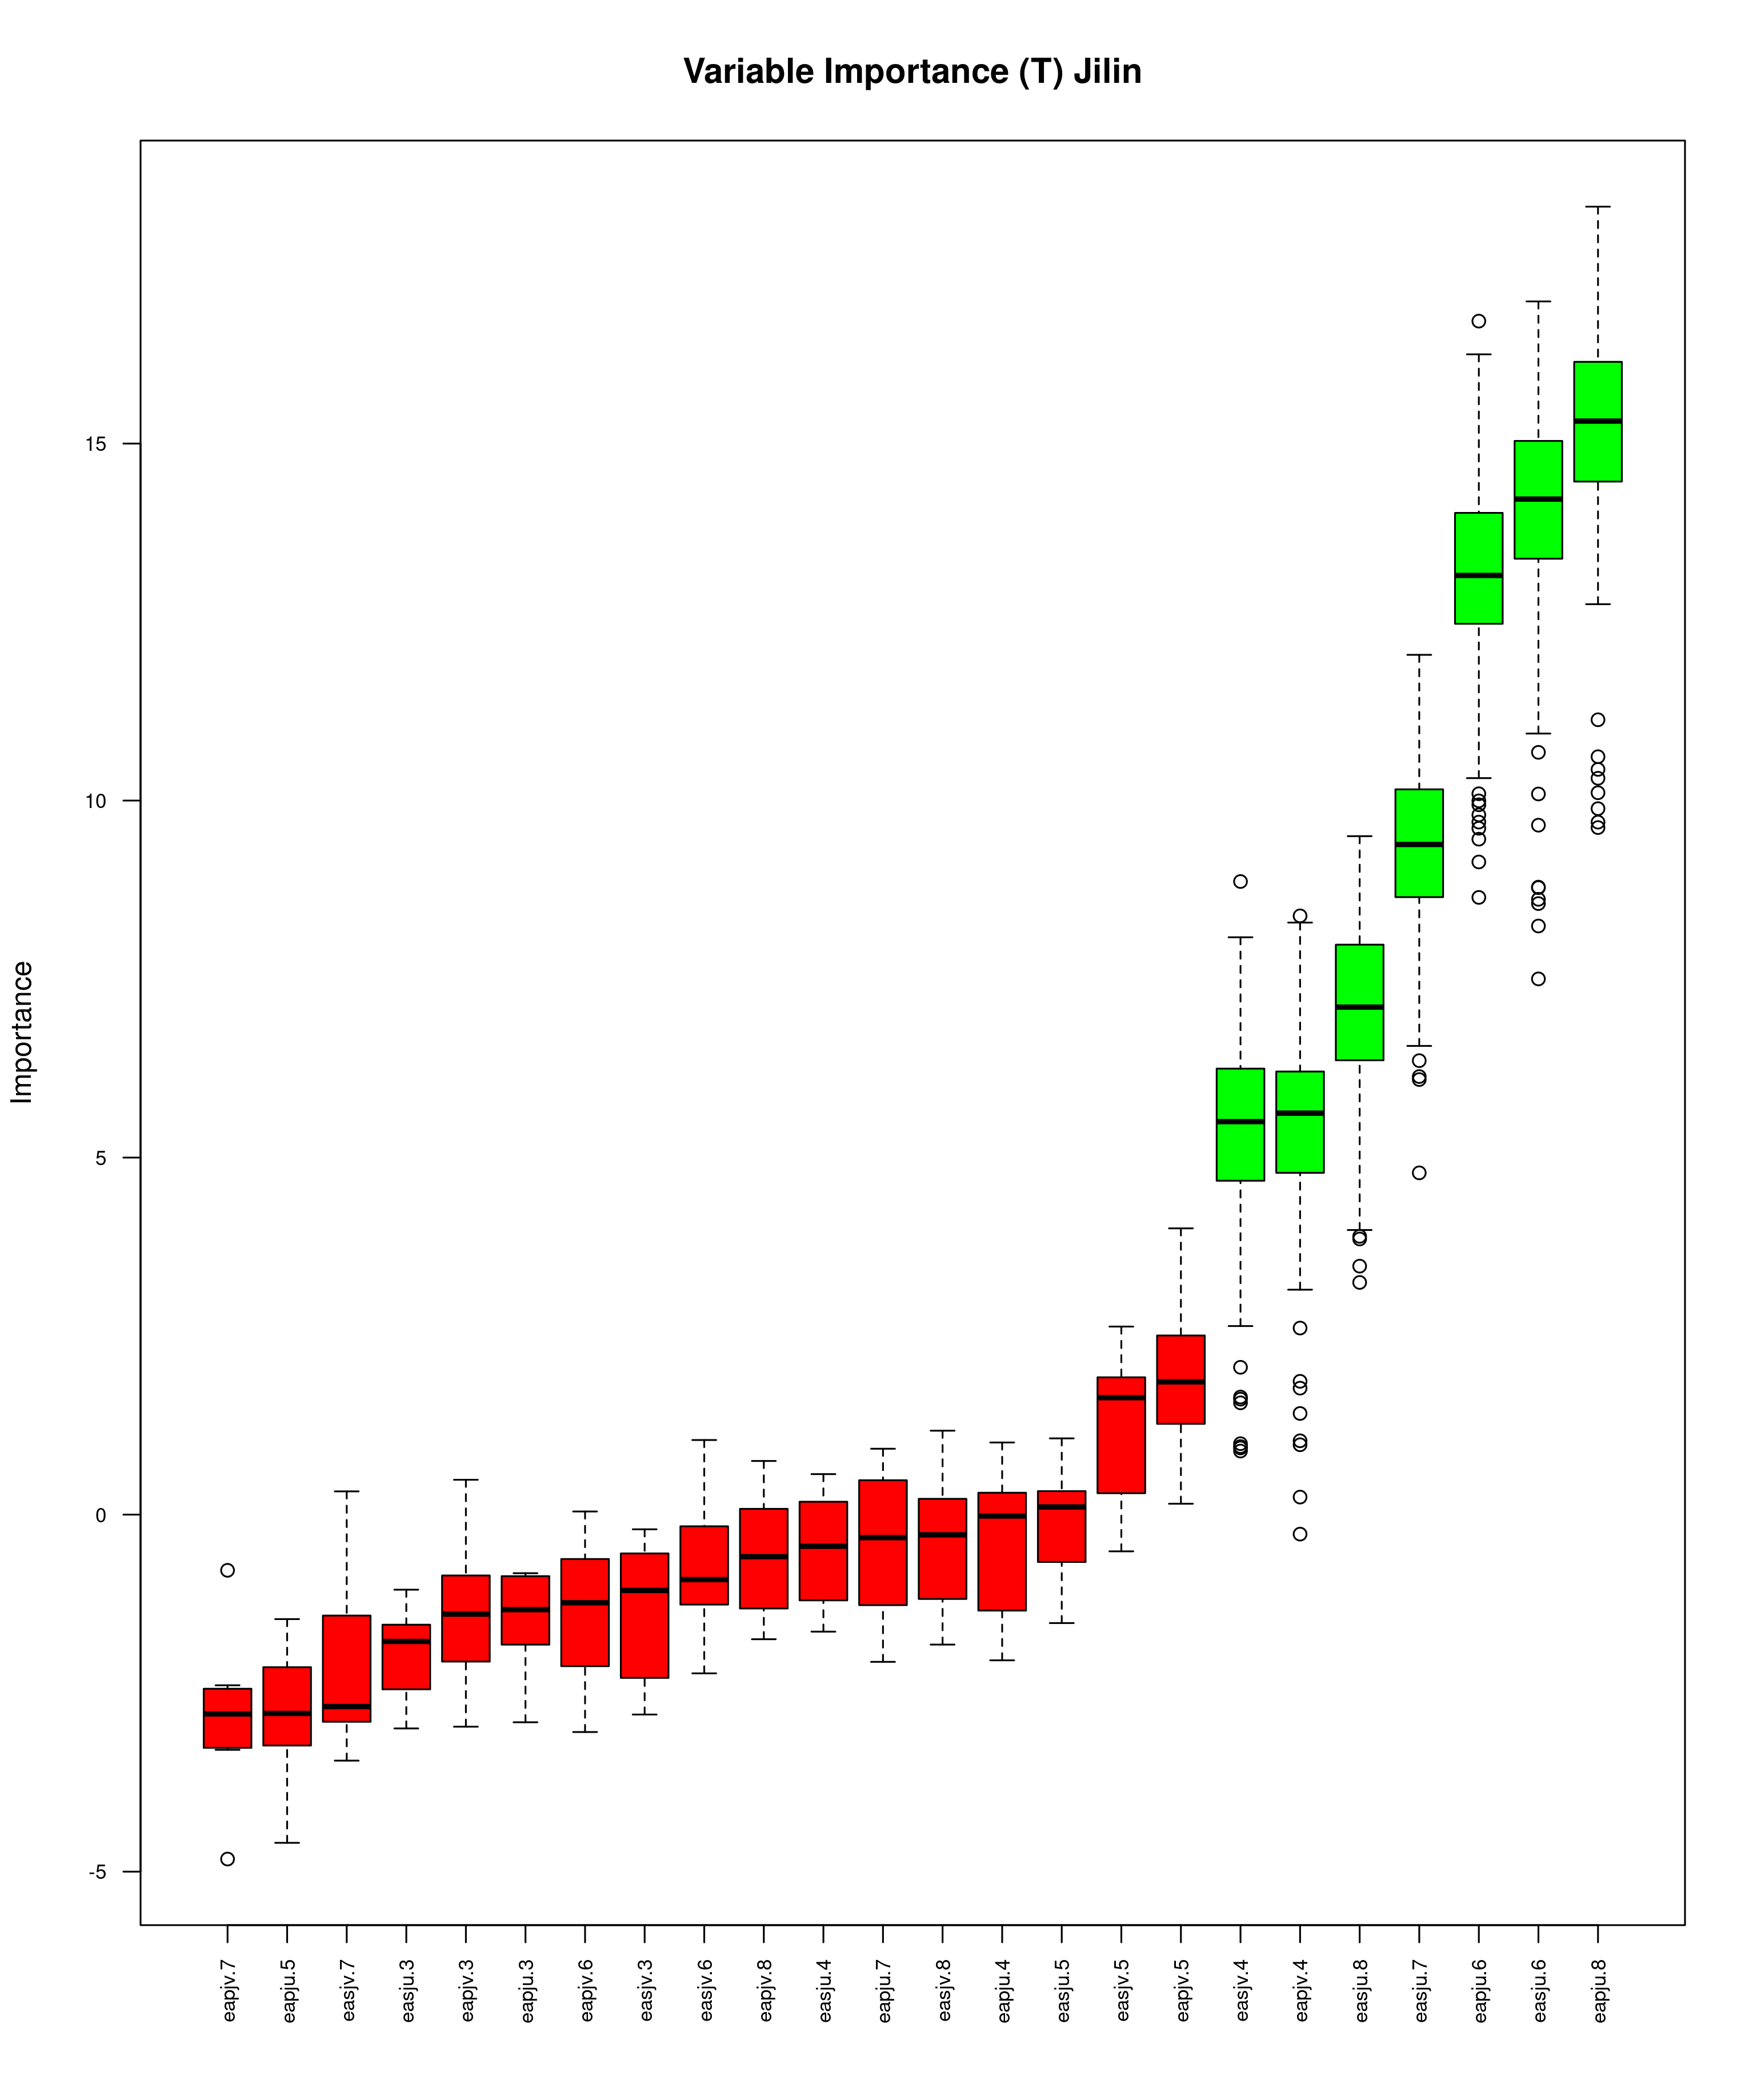

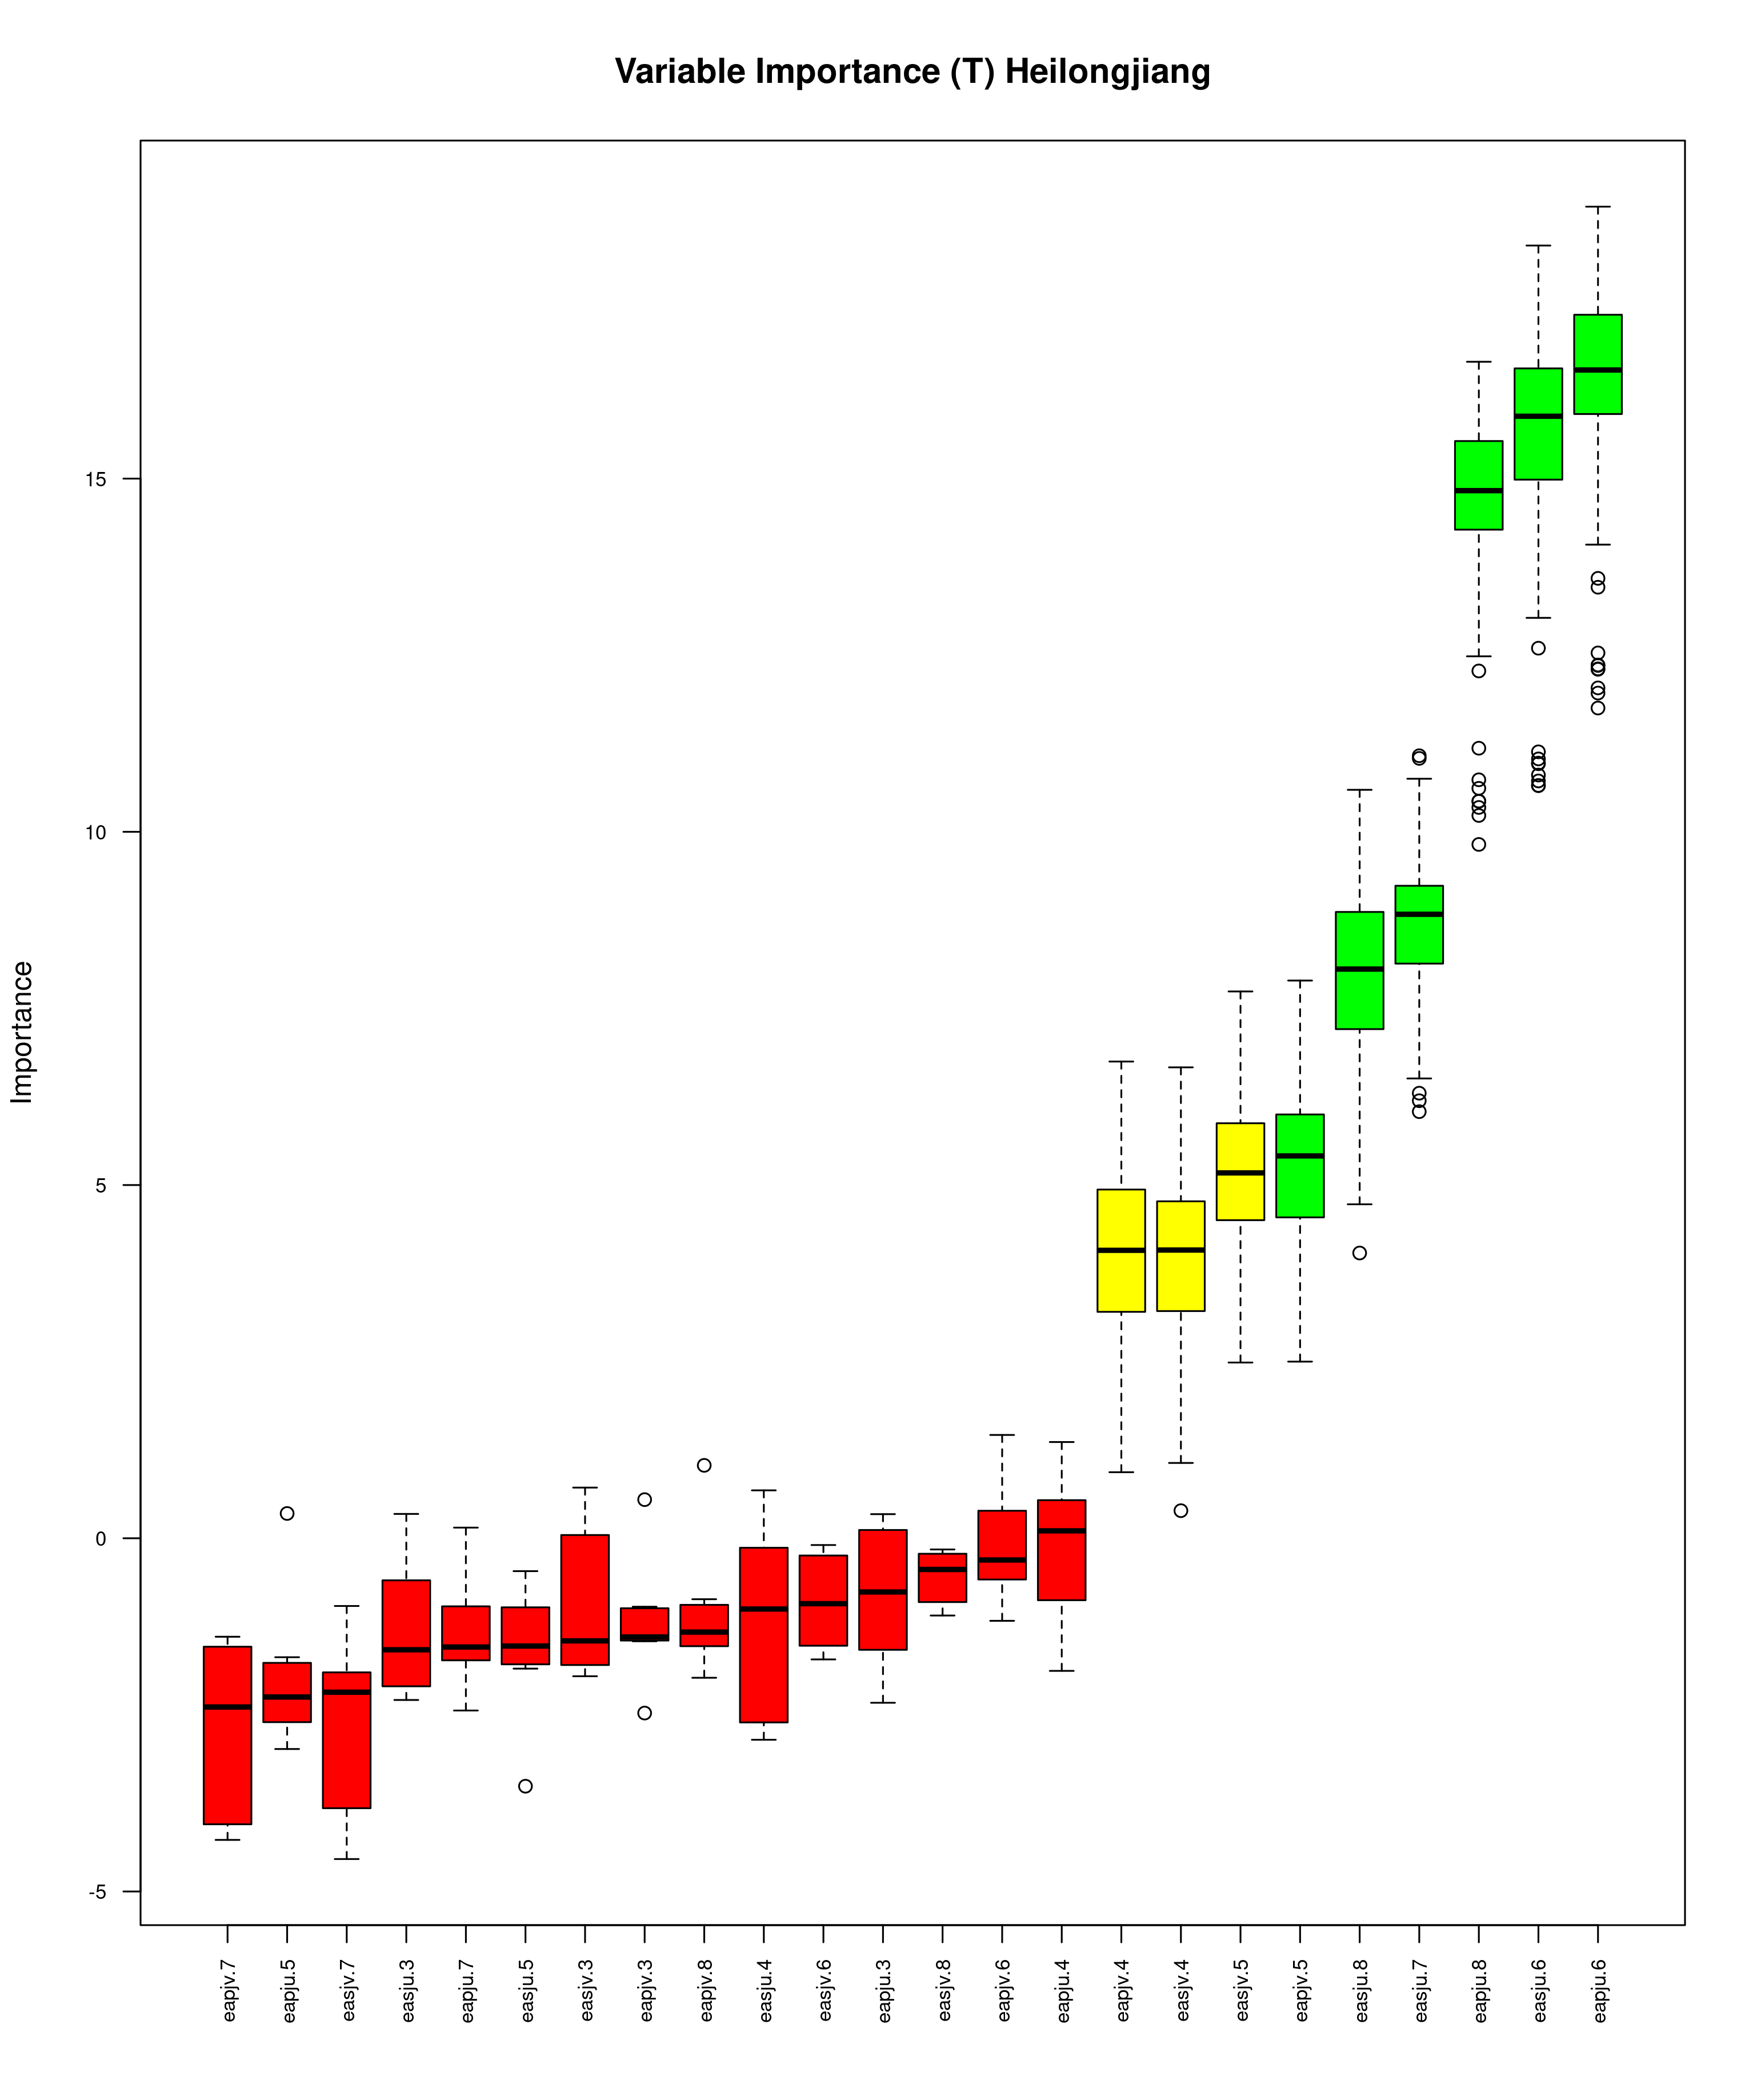

In [31]:
for (k in 1:length(regs)) {
    fname = paste('./china_maize_jet_varimp_',regs[k],'_',ystrts,'_',yends,"_lag_",lag,'_',suffix,'.png', sep="")
    png(fname,width=10.25,height=12.25,units="in",res=300)
    plot(rf_jet_results[[regs[k]]], cex.axis=.7, las=2, xlab="", main=paste("Variable Importance (T)", regs[k]), whichShadow = c(FALSE, FALSE, FALSE))
    dev.off()
    display_png(file=fname, width=750) 
}

<a id='section_4'></a>
## Section 4: Feature refinement  
* Creating Bayseian Networks between selected jet and climate indices 

In [75]:
options(warn = -1) # suppress warnings
library(bnlearn)
library(igraph)
library(compare)

Function to impose temporal and causal limitations on the Bayesian network

In [76]:
get_blacklist2 <- function(mat, cindex_cols, eff_cols, monlist) {
  # mat is a data matrix containing causes and effects
  # eff_cols are the columns for the effects
  ##   
  # create a list of forbidden links, i.e. non-causal links
  # prevent regions from predicting each other and effects resulting in causes.
  cneffs = length(cindex_cols)  
  neffs = length(eff_cols)  
  # split the names
  tns = strsplit(colnames(mat), ".", fixed = TRUE)
  # put in a matrix
  tnsmat = matrix(unlist(tns),ncol=2,byrow=T)
  # order the months
  from_mons = numeric(0)   
  for (i in 1:(dim(mat)[2]-neffs)) {
    #     print(i)
    from_mons[i] = which(as.numeric(tnsmat[i,2]) == monlist)
  }
  
  # find which links would be backwards in time
  from_to = numeric(0)
  for (i in 1:length(from_mons)) {
    to_mons = which(from_mons < from_mons[i])
    from_names = rep(colnames(mat)[i], times=length(to_mons))
    to_names = colnames(mat)[to_mons]
    from_to_new = cbind(from_names, to_names)
    # now add to "from_to"  
    from_to = rbind(from_to, from_to_new)
  }
  # make sure each effect can't cause anything, repeat over all effect columns
  #from_names = rep(colnames(mat)[dim(mat)[2]], times=(dim(mat)[2]-neffs))
  #to_names = colnames(mat)[1:(dim(mat)[2]-neffs)]
  for (k in 1:neffs) {
    # get the name of the effect, and repeat by the number of columns - 1 (i.e. from itself to every other column)
    from_names = rep(colnames(mat)[eff_cols[k]], times=(dim(mat)[2]-1))
    # link to all other columns (just drop the current col name)
    to_names = colnames(mat)[-eff_cols[k]]
    from_to_new = cbind(from_names, to_names)
    ## Add to "from to"
    from_to = rbind(from_to, from_to_new)
  }
  
  if (cneffs != 0) {
    for (k in 1:neffs) {
    # get the name of the climate index effect, and repeat by the number of effects)
      from_names = colnames(mat)[cindex_cols]
    # link to all effects
      to_names = rep(colnames(mat)[eff_cols[k]], times=length(from_names))
      from_to_new_new = cbind(from_names, to_names)
    ## Add to "from to"
      from_to = rbind(from_to, from_to_new_new)
    }
  }  
  # return th list
  return(from_to) 
}

Setup variables needed

In [77]:
## Create networks, store networks, parents and predictor performance
t_parent = vector("list", length = length(regs))
t_parent_all = vector("list", length = length(regs))

tbn_all = vector("list", length = length(regs))
t_loss = array(NA, c(length(regs)))

dx = 1+dim(cindex_anoms)[2]
dx2 = 1+dim(jet_anoms)[2]
# need a column for the intercepts
  #(length(ind_list)*length(yrs_array[1,]))
sub= 2:dx
sub2 = 2:dx2


t_inds_all_all = unique(which(abs(coef_array_full[,2,sub]) > 0.5, arr.ind=TRUE)[,2])
tj_inds_all_all = unique(which(abs(coef_jarray_full[,2,sub2]) > 0.5, arr.ind=TRUE)[,2])
inds_all = unique(c(t_inds_all_all))
jinds_all = unique(c(tj_inds_all_all))

# generate the network including jets 
tmat3 = data.frame(cindex_anoms[,t_inds_all_all], jet_anoms[,tj_inds_all_all], temp_anoms)
                   #jet_anoms, temp_anoms)
                   #j
all_mon_list = unique(c(mon_list, jmons_num))
# indices of the effects
eff_cols = (dim(tmat3)[2]-length(regs) + 1):dim(tmat3)[2]
cindex_cols = 1:(dim(cindex_anoms[, t_inds_all_all])[2])

Create a list of forbidden links, i.e. non-causal links

In [78]:
tbl3 = get_blacklist2(tmat3, cindex_cols, eff_cols, all_mon_list)

Learn the structure of a Bayesian network using a hill-climbing (HC) greedy search, i.e. generate the Bayesian network

In [79]:
ga = bnlearn::hc(tmat3, blacklist = tbl3)
ga


  Bayesian network learned via Score-based methods

  model:
   [snao.9][scand.9][pstratu.10][pstratu.11][seu.10|scand.9]
   [cgt.12|snao.9:scand.9][pstratu.12|pstratu.11][mjopc1a.9|snao.9]
   [mjopc1b.12|pstratu.10][eapju.8|snao.9][eapjv.4|snao.9][easjv.4|snao.9]
   [scand.4|pstratu.11:mjopc1b.12][peu.2|mjopc1b.12]
   [mjopc1b.9|scand.9:mjopc1a.9][easju.8|eapju.8]
   [peu.12|seu.10:pstratu.11:mjopc1b.9]
   [mjopc1a.2|cgt.12:mjopc1a.9:mjopc1b.9:mjopc1b.12][snao.12|peu.12]
   [mjopc1b.2|scand.9:pstratu.10:mjopc1a.2:mjopc1b.12][iod.3|snao.12:mjopc1a.9]
   [nin3.3|snao.12:pstratu.10:mjopc1a.9:mjopc1a.2]
   [eawr.12|snao.12:scand.9:mjopc1a.9][iod.4|iod.3:eawr.12:peu.2]
   [mjopc1a.3|nin3.3:snao.9][eapjv.5|nin3.3][easju.6|iod.3:eawr.12:pstratu.11]
   [easjv.5|nin3.3][nin3.4|nin3.3:mjopc1a.3:mjopc1b.2]
   [peu.3|iod.3:scand.9:cgt.12:mjopc1a.3][mjopc1b.3|pstratu.10:mjopc1a.3]
   [easju.7|cgt.12:easju.6][eapju.6|seu.10:mjopc1b.3:easju.6]
   [Liaoning.T|eapju.8:easju.7][Jilin.T|eapju.6:eapju.8

Measure the strength of all possible probabilistic relationships expressed by the arcs of the Bayesian network, as learned from bootstrapped data.

In [80]:
g2 = bnlearn::boot.strength(tmat3, R = 1000, algorithm = "hc", algorithm.args = list(blacklist = tbl3, score="bic-g"))
head(g2)

,from,to,strength,direction
,<chr>,<chr>,<dbl>,<dbl>
1,iod.3,iod.4,0.847,1.0000000
2,iod.3,nin3.3,0.325,0.5815385
3,iod.3,nin3.4,0.433,1.0000000
4,iod.3,seu.10,0.162,0.0000000
5,iod.3,snao.9,0.270,0.0000000
6,iod.3,snao.12,0.691,0.0000000


Find minimum threshold for which each variable in the Bayesian network has at least one link to it.

In [81]:
#g2_thrsh = g2[,3]
thrsh = seq(0.0,1.0, length.out=100)
  #sort(g2_thrsh, decreasing=T)
t_all_linked = character(0)
## loop through threshold to find minimum threshold for which each variable has at least one link to it.
for (h in 1:length(thrsh)) {
  t_all_linked[h] = compare::compare(unique(g2[,2]), unique(g2[which(g2[,3] >= thrsh[h]),2]), allowAll = TRUE, shorten = FALSE)$result
#  print(unique(g2[which(g2[,3] >= g2sorted_thrsh[h]),2]))
}
## find minimum threshold for which all nodes have at least one link to them.
tmin_ind = max(which(t_all_linked == TRUE))

Use model averaging to build a network containing only the significant arcs, ~~using the at-least-one-link threshold above~~.

TODO: Should we use the threshold or not?

In [82]:
gta = bnlearn::averaged.network(g2)
#, threshold=thrsh[tmin_ind])
#browser()

Fit the Bayesian network, given the structure `gta` and dataset `tmat3`

TODO: What does this actually do?

In [83]:
gbna = bnlearn::bn.fit(gta, tmat3)

Get parents of parents, i.e. what are the cliamte indices that predict the jets that predict temperature.

In [84]:
## get parents of parents, i.e. what are the cliamte indices that predict the jets that predict temperature. 
for (k in 1:length(regs)) {
  ## get parents
  tps = parents(gbna, colnames(tmat3)[eff_cols[k]])
  tns = character(0)
  ## loop through parents to find their parents
  for (n in 1:length(tps)) {
    tpars = parents(gbna, tps[n])
    cinds = gsub("[[:punct:]]", ".", colnames(cindex_anoms)[t_inds_all_all])
    tpars_match = match(cinds, tpars)
    tns = c(tns, cinds[which(!is.na(tpars_match))])
  }
  t_parent_all[[k]] = unique(tns)
}

Use `igraph` to build a graph of the Bayesian network for plotting

In [85]:
#gbna = bn.fit(ga, tmat3)
gga = igraph::as.igraph(gta)
gg2a = igraph::simplify(gga)
isolateda = which(degree(gg2a)==0)
gg3a = igraph::delete.vertices(gg2a, isolateda)
la = igraph::layout_with_gem(gg3a)
## get p-value of each link
gbnas = bnlearn::arc.strength(gta, tmat3)
igraph::E(gg3a)$color <- "gray"
igraph::E(gg3a)[adj("Liaoning.T")]$color = "black"
igraph::E(gg3a)[adj("Jilin.T")]$color = "black"
igraph::E(gg3a)[adj("Heilongjiang.T")]$color = "black"

In [86]:
# Get names
tnetworknames = gsub("[[:punct:]]", "-", names(degree(gg3a)))
tclim_inds = match(colnames(cindex_anoms)[t_inds_all_all], tnetworknames)
tjet_inds =  match(colnames(jet_anoms)[tj_inds_all_all], tnetworknames)
colst = c(rep("Orange", times = length(tclim_inds[is.finite(tclim_inds)])), rep("Yellow", times = length(tjet_inds[is.finite(tjet_inds)])), rep("white", times=length(regs)))
varname = "all temperature"
vname = "all_temperature"

Plot network `gg3a`

png 
  2

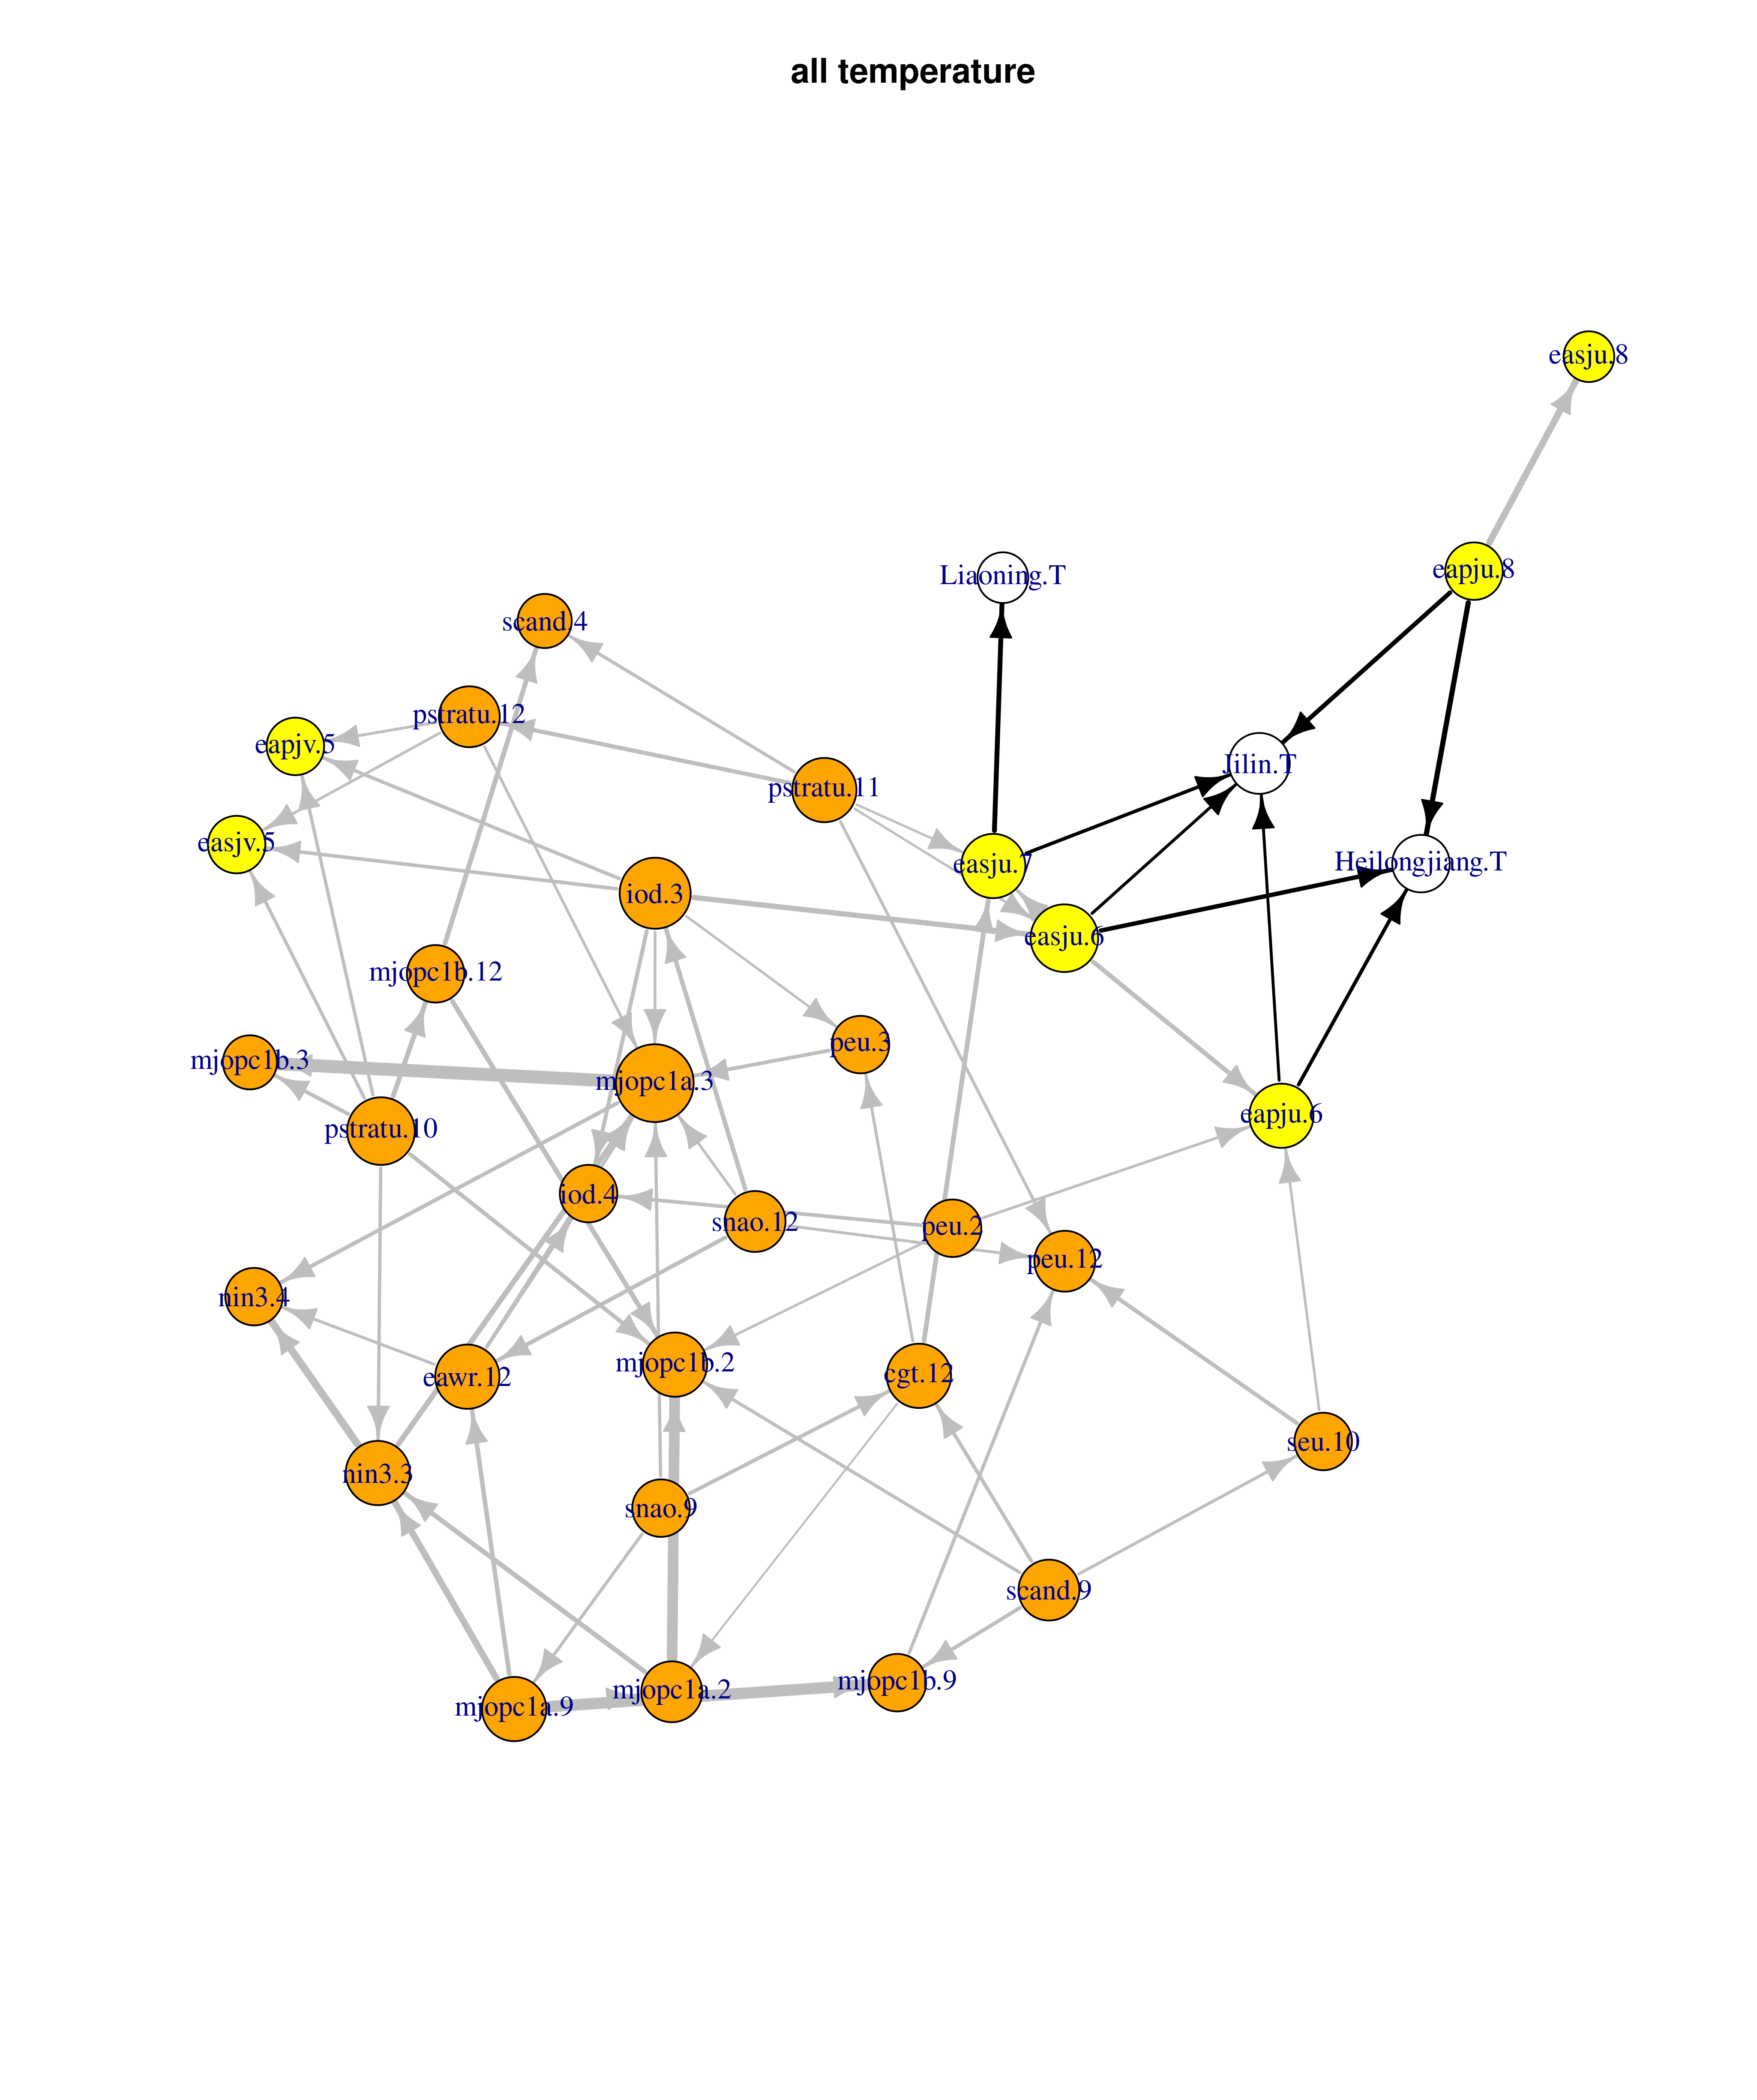

In [87]:
fname = paste('./china_maize_network_',vname,'_jet_',ystrts,'_',yends,"_lag_",lag,"_",suffix,'.png', sep="")
png(fname, width=10.25,height=12.25,units="in",res=400)
plot(gg3a, layout=la, edge.width = sqrt(-log(gbnas[,3])), vertex.size = 7.0+0.5*degree(gg3a), vertex.color = colst, cex=4, main=varname, resolution=2)
dev.off()
display_png(file=fname, width=750) 

### 5-fold cross validated Bayesian network
Assess the performance of forecasts produced by k-fold cross validation of a Bayesian network constructed from the predictors in Table 4 and the province temperatures for 1981-2016.

In [139]:
## province cross validation
print("Cross validation of temperature predictions in network")
liaoning_t = bn.cv(tmat3, gta, loss = "cor", loss.args = list(target = "Liaoning.T"), k=5, runs=50)
jilin_t = bn.cv(tmat3, gta, loss = "cor", loss.args = list(target = "Jilin.T"), k=5, runs=50)
heilongjiang_t = bn.cv(tmat3, gta, loss = "cor", loss.args = list(target = "Heilongjiang.T"), k=5, runs=50)
print(liaoning_t)
print("jilin_t")
print(jilin_t)
print("heilongjiang_t")
print(heilongjiang_t)

[1] "Cross validation of temperature predictions in network"

  k-fold cross-validation for Bayesian networks

  target network structure:
   [snao.9][snao.12][scand.9][peu.2][pstratu.10][pstratu.11][eapjv.4][easjv.4]
   [iod.3|snao.12][seu.10|scand.9][cgt.12|snao.9:scand.9][mjopc1a.9|snao.9]
   [mjopc1b.12|pstratu.10][eapju.8|snao.9][scand.4|pstratu.11:mjopc1b.12]
   [eawr.12|snao.12:mjopc1a.9][peu.3|iod.3:cgt.12][pstratu.12|cgt.12:pstratu.11]
   [mjopc1a.2|cgt.12:mjopc1a.9][mjopc1b.9|scand.9:mjopc1a.9]
   [easju.6|iod.3:pstratu.11][easju.8|eapju.8][iod.4|iod.3:eawr.12:peu.2]
   [nin3.3|pstratu.10:mjopc1a.9:mjopc1a.2]
   [peu.12|seu.10:snao.12:pstratu.11:mjopc1b.9]
   [mjopc1b.2|scand.9:peu.2:pstratu.10:mjopc1a.2:mjopc1b.12]
   [eapjv.5|iod.3:pstratu.10:pstratu.12][easju.7|cgt.12:pstratu.11:easju.6]
   [easjv.5|iod.3:pstratu.10:pstratu.12]
   [mjopc1a.3|iod.3:nin3.3:snao.9:eawr.12:peu.3:pstratu.12][Liaoning.T|easju.7]
   [nin3.4|nin3.3:eawr.12:mjopc1a.3][mjopc1b.3|pstratu.10:mjopc1a.3

<a id='section_6'></a>
## Section 6: Statistical forecast
* Linear regression

### Unknown

In [ ]:
t_parent_all

In [ ]:
for (k in 1:length(regs)) {
    t_inds2a = gsub("[[:punct:]]", "-", t_parent_all[[k]])
    #print(t_inds2a)
    t_inds2 = t_inds2a[which(abs(cor(cindex_anoms[, t_inds2a], temp_anoms[,k])) >= critical.r(length(temp_anoms[,k]), 0.2))]
    print(t_inds2)
    }

In [ ]:
for (k in 1:length(regs)) {
    # get the T and P indexs of significant varibles 
    t_inds = which(abs(coef_array_full[k,2,sub]) > 0.5)
    p_inds = which(abs(coef_array_full[k,3,sub]) > 0.5)
    
    for (y in 1:length(years)) {
        #print(y)
        rind = y
        tt = 1:length(temp_jja[-rind,k]) # TO DO isnt this just always 1:35 ? 
        lmmodt = lm(temp_jja[-rind,k] ~ tt) # temp_jja[-rind, k] ~ tt # gets all the years other than -rind for that area
        lmmodp = lm(precip_jja[-rind,k] ~ tt)

        # get mean T/P for the missing year    
        ttout_of_sample_data <- data.frame(tt = t(rind))
        tmean_pred = predict(lmmodt, ttout_of_sample_data, se.fit = TRUE)$fit
        pmean_pred = predict(lmmodp, ttout_of_sample_data, se.fit = TRUE)$fit
        
        
        if (length(t_inds) > 0) {
            tmod = automate_predict("t", lmmodt$residuals, cindex_anoms[-rind,t_inds], cindex_anoms[rind,t_inds])
            tmod_fit = tmod$model$fitted.values
            t_loocv[y,k] = tmod$pred
            t_effcv[y,k,t_inds] = tmod$effects
            t_int[y,k] = tmod$model$coefficients[1]
            frac = abs(t_effcv[y,k,t_inds])/sum(abs(t_effcv[y,k,t_inds]))
            t_ent[y,k] = -1.0*sum(frac*log(frac))

            ## forecast using random forests      
            set.seed(2019)
            # fit the model
            if (length(t_inds) > 1) {
                fit_rft <- randomForest(x=cindex_anoms[-rind,t_inds], y=lmmodt$residuals)
                t_loocv_rf[y,k] <- predict(fit_rft, cindex_anoms[rind,t_inds])
            } else {
                t_loocv_rf[y,k] <- 0.0
            }
        }
        
        if (length(p_inds) > 0) {
            pmod = automate_predict("p", lmmodp$residuals, cindex_anoms[-rind,p_inds], cindex_anoms[rind,p_inds])
            pmod_fit = pmod$model$fitted.values
            p_loocv[y,k] = pmod$pred
            p_effcv[y,k,p_inds] = pmod$effects
            p_int[y,k] = pmod$model$coefficients[1]
            ## calculate entropy each year
            frac = abs(p_effcv[y,k,p_inds])/sum(abs(p_effcv[y,k,p_inds]))
            p_ent[y,k] = -1.0*sum(frac*log(frac))

            if (length(p_inds) > 1) {
                fit_rfp <- randomForest(x=cindex_anoms[-rind,p_inds], y=lmmodp$residuals)
                p_loocv_rf[y,k] <- predict(fit_rfp, cindex_anoms[rind,p_inds])
            } else {
                p_loocv_rf[y,k] <- 0.0
            }
        }
        
        t_train = lmmodt$fitted.values + tmod_fit
        p_train = lmmodp$fitted.values + pmod_fit

        t_oos = tmean_pred + tmod$pred
        p_oos = pmean_pred + pmod$pred

        t_oos_rf = tmean_pred + t_loocv_rf[y,k]
        p_oos_rf = pmean_pred + p_loocv_rf[y,k]

        ## also save out absolute temp and rainfall      
        p_abs_loocv[y,k] = p_oos
        t_abs_loocv[y,k] = t_oos

        p_abs_loocv_rf[y,k] = p_oos_rf
        t_abs_loocv_rf[y,k] = t_oos_rf
    
    }
}

In [ ]:
t_loocv[,1]

In [ ]:
head(t_loocv)

In [ ]:
cor(t_loocv[, 1], temp_anoms[,1])

In [ ]:
head(temp_anoms)

### Creating stacked plots 

In [ ]:
create_df<-function(ind_effect, obs, yrs, monlist, indlist){
    v_inds = which(ind_effect[1,] != 0)
    vnames2 = names(v_inds)
    tt = 1:length(obs)
    lmmod = lm(obs ~ tt)
    year <- rep(yrs, each=length(v_inds))
    index <- rep(vnames2, times=length(yrs))
    value <- as.vector(t(ind_effect[,v_inds]))
    data <- data.frame(year,index,value)
    obs_resids = as.vector(lmmod$residuals)
    d2 <-data.frame(years, obs_resids)
    df <- data.frame(data)
    df$bar_heights <- rep(tapply(data$value, data$year, sum), each=length(v_inds))
    df$line_y <- rep(obs_resids,each=length(v_inds))

    return(df)
}

In [ ]:
for (k in 1:length(regs)) {
    df_temp = create_df(t_effcv[,k,], temp_anoms[,k], rownames(temp_jja), mon_list, ind_list)
    df_precip = create_df(p_effcv[,k,], precip_anoms[,k], rownames(temp_jja), mon_list, ind_list)
  # Stacked
  #  dev.new()
    p <- ggplot(df_temp, aes(fill=index, y=value, x=year)) + 
        geom_bar(position="stack", stat="identity") + 
        ggtitle(regs[k]) + xlab("Year") + 
        ylab(paste(suffix," temperature (\u00B0C)",sep="")) +
        theme(axis.text.x = element_text(angle = 90)) +
        theme(text = element_text(size=14))
    #p  + 
        #geom_line(aes(x=year, y=line_y), colour = "black") + 
        #geom_line(aes(x=year, y=bar_heights), colour = "red")
    print(p)
 #   p  + theme(text = element_text(size=20))
    #ggsave(paste("./", region,"_temp_stacked_",num_vars,'_',ystrts,'_',yends,"_",regs[k],"_lag_",lag,'_',suffix,".png", sep=""), width = 9, height = 5, dpi = 400, units = "in")
    
    q <- ggplot(df_precip, aes(fill=index, y=value, x=year)) + 
        geom_bar(position="stack", stat="identity") + 
        ggtitle(regs[k]) + xlab("Year") + 
        ylab(paste(suffix," precipitation (mm)", sep="")) + 
        theme(axis.text.x = element_text(angle = 90)) + 
        theme(text = element_text(size=14))
    q + geom_line(aes(x=year, y=line_y), colour = "black") + 
        geom_line(aes(x=year, y=bar_heights), colour = "red")
    print(q)
    #ggsave(paste("./", region,"_precip_stacked_",num_vars,'_',ystrts,'_',yends,"_",regs[k],"_lag_",lag,"_",suffix,".png", sep=""), width = 9, height = 5, dpi = 400, units = "in")
    
}

### Producing Linear Model with subset of predictors 

In [ ]:
t_loocv_red = create_empty_dataframe(rownames(temp_jja), regs)
p_loocv_red = create_empty_dataframe(rownames(temp_jja), regs)

t_effcv_red = array(NA, c(length(years),length(regs), dim(cindex_anoms)[2]))
p_effcv_red = array(NA, c(length(years),length(regs), dim(cindex_anoms)[2]))
dimnames(t_effcv_red)[[3]] <- colnames(cindex_anoms)
dimnames(p_effcv_red)[[3]] <- colnames(cindex_anoms)

In [ ]:
dim(cindex_anoms)[2]

In [ ]:
for (k in 1:length(regs)) {
    # get the T and P indexs of significant varibles 
    
    t_inds_red = gsub("[[:punct:]]", "-", t_parent[[k]])
    p_inds_red = gsub("[[:punct:]]", "-", p_parent[[k]])
    
    for (y in 1:length(years)) {
        #print(y)
        rind = y
        tt = 1:length(temp_jja[-rind,k]) # TO DO isnt this just always 1:35 ? 
        lmmodt = lm(temp_jja[-rind,k] ~ tt) # temp_jja[-rind, k] ~ tt # gets all the years other than -rind for that area
        lmmodp = lm(precip_jja[-rind,k] ~ tt)

        # get mean T/P for the missing year    
        ttout_of_sample_data <- data.frame(tt = t(rind))
        tmean_pred = predict(lmmodt, ttout_of_sample_data, se.fit = TRUE)$fit
        pmean_pred = predict(lmmodp, ttout_of_sample_data, se.fit = TRUE)$fit
        
        
        if (length(t_inds_red) > 0) {
            tmod = automate_predict("t", lmmodt$residuals, cindex_anoms[-rind,t_inds_red], cindex_anoms[rind,t_inds_red])
            tmod_fit = tmod$model$fitted.values
            t_loocv_red[y,k] = tmod$pred
            t_effcv_red[y,k,t_inds_red] = tmod$effects

        }
        
        if (length(p_inds_red) > 0) {
            pmod = automate_predict("p", lmmodp$residuals, cindex_anoms[-rind,p_inds_red], cindex_anoms[rind,p_inds_red])
            pmod_fit = pmod$model$fitted.values
            p_loocv_red[y,k] = pmod$pred
            p_effcv_red[y,k,p_inds_red] = pmod$effects

        }
    
    }
}

In [ ]:
cor(t_loocv_red[, 1], temp_anoms[,1])

In [ ]:
p_inds_red

In [ ]:
cor(p_loocv_red[, 3], precip_anoms[,3])

In [ ]:
typeof(df_temp$line_y)

In [ ]:
typeof(df_temp$year)

In [ ]:
df_temp$year <- as.numeric(df_temp$year)

In [ ]:
df_temp$line_y <- as.numeric(df_temp$line_y)

In [ ]:
z = geom_line(data=df_temp, aes(x=year, y=line_y), colour = "black")

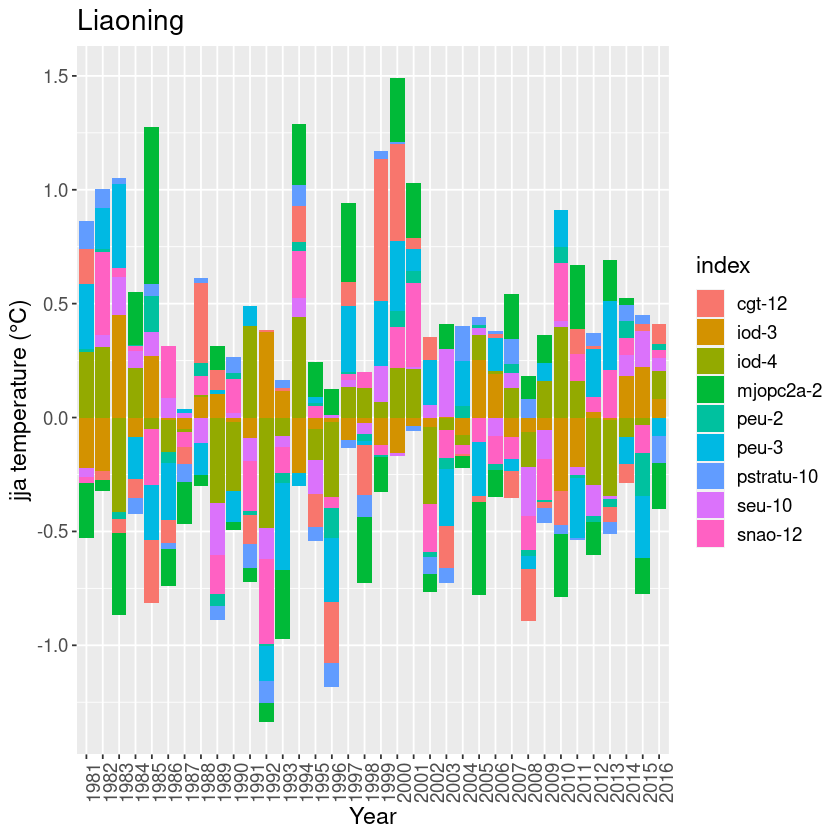

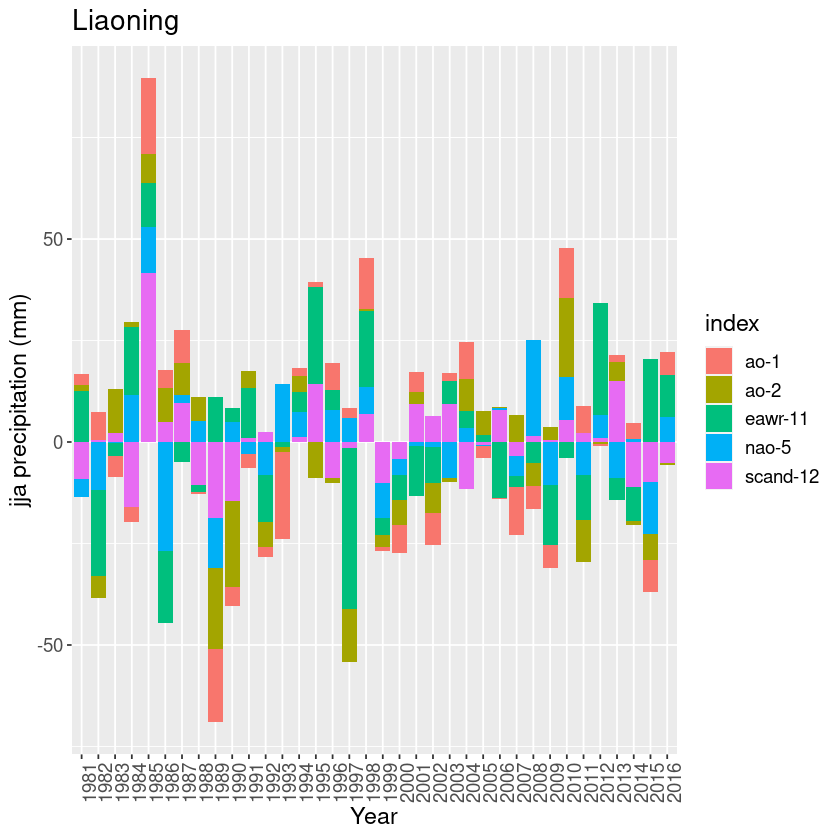

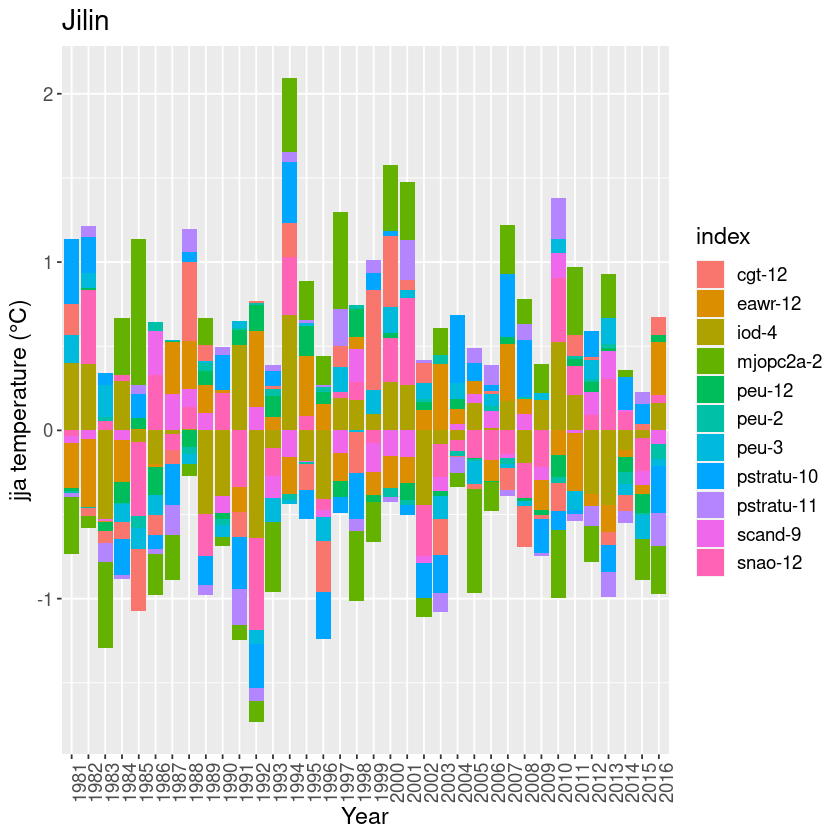

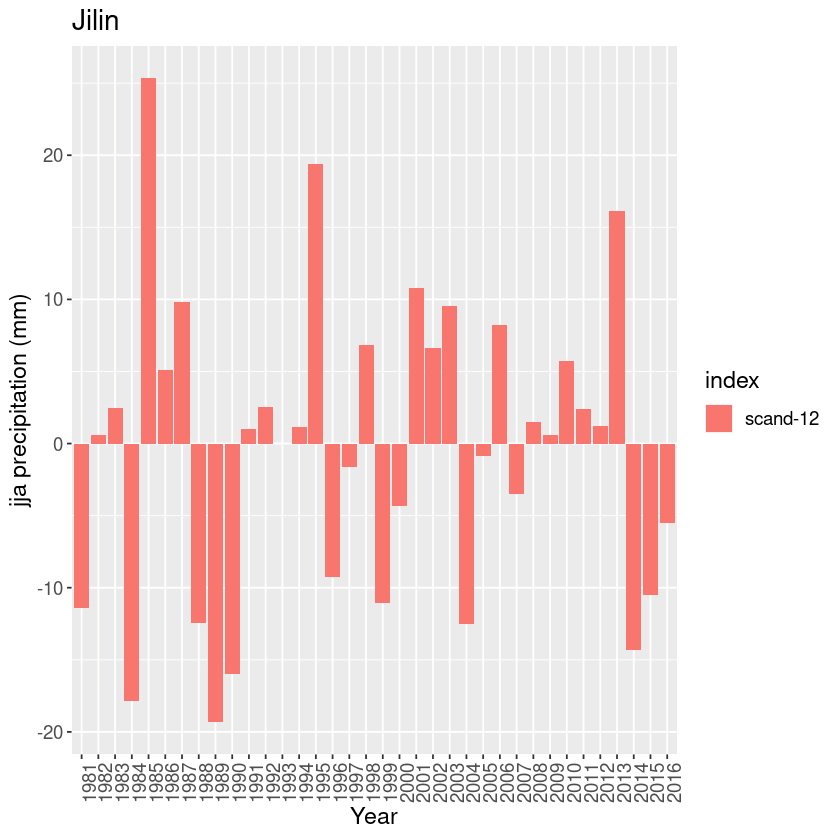

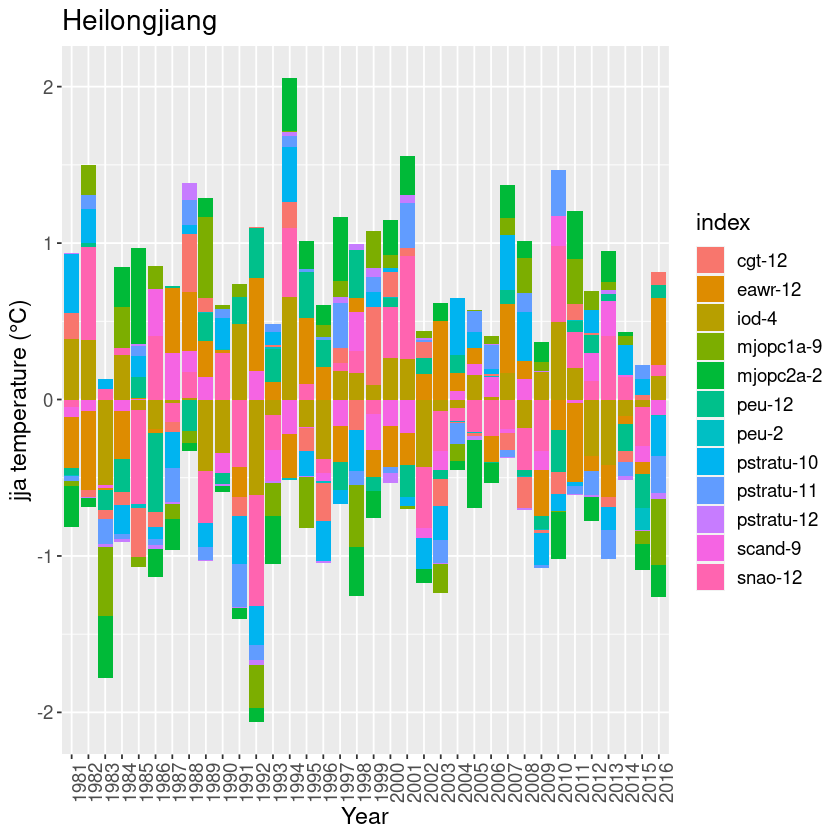

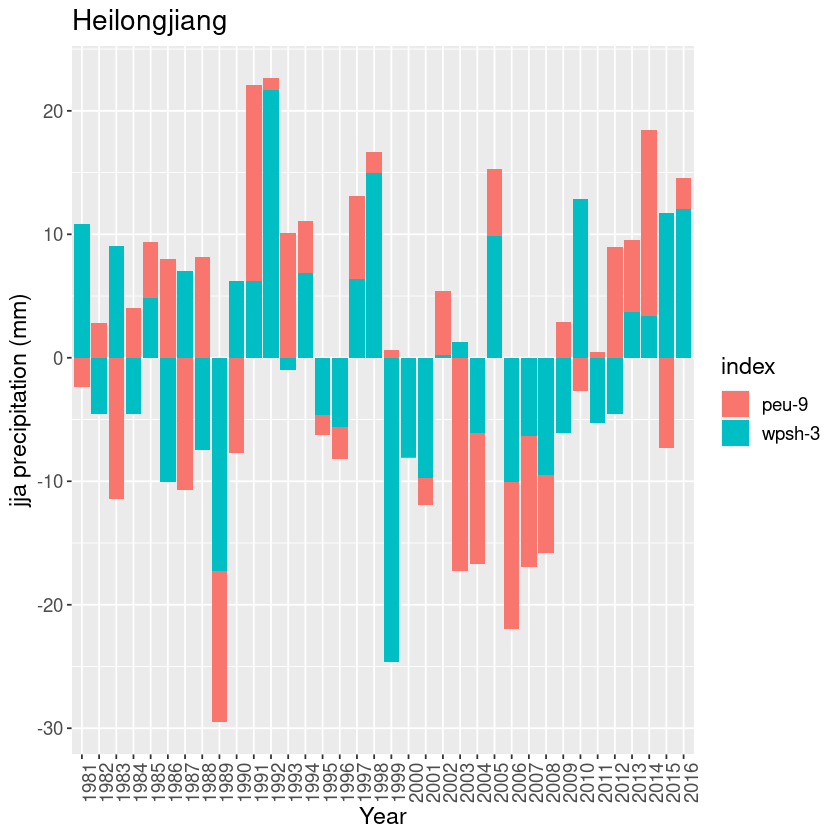

In [ ]:
for (k in 1:length(regs)) {
    df_temp = create_df(t_effcv_red[,k,], temp_anoms[,k], rownames(temp_jja), mon_list, ind_list)
    df_precip = create_df(p_effcv_red[,k,], precip_anoms[,k], rownames(temp_jja), mon_list, ind_list)
  # Stacked
  #  dev.new()
    p <- ggplot(df_temp, aes(fill=index, y=value, x=year, group=1)) + 
        geom_bar(position="stack", stat="identity") + 
        ggtitle(regs[k]) + xlab("Year") + 
        ylab(paste(suffix," temperature (\u00B0C)",sep="")) +
        theme(axis.text.x = element_text(angle = 90)) +
        theme(text = element_text(size=14)) 
    p + 
        geom_line(aes(x=year, y=line_y), colour = "black") + 
        geom_line(aes(x=year, y=bar_heights), colour = "red")
    print(p)
    p  + theme(text = element_text(size=20))
    #ggsave(paste("./", region,"_temp_stacked_",'_',ystrts,'_',yends,"_",regs[k],"_lag_",lag,'_',suffix,".png", sep=""), width = 9, height = 5, dpi = 400, units = "in")
    
    q <- ggplot(df_precip, aes(fill=index, y=value, x=year)) + 
        geom_bar(position="stack", stat="identity") + 
        ggtitle(regs[k]) + xlab("Year") + 
        ylab(paste(suffix," precipitation (mm)", sep="")) + 
        theme(axis.text.x = element_text(angle = 90)) + 
        theme(text = element_text(size=14))
    q + geom_line(aes(x=year, y=line_y), colour = "black") + 
        geom_line(aes(x=year, y=bar_heights), colour = "red")
    print(q)
    #ggsave(paste("./", region,"_precip_stacked_",num_vars,'_',ystrts,'_',yends,"_",regs[k],"_lag_",lag,"_",suffix,".png", sep=""), width = 9, height = 5, dpi = 400, units = "in")
    
}

### Leave-one-out cross validated linear regression
The selected climate indices given in Table 4 are used to build multiple-linear regression models and forecast the mean summer temperatures in each province for 1981-2016, trained and tested using leave-one-out (LOOCV) and k-fold cross-validation.

### 5-fold cross validated linear regression


### Linear Mixed Effects Model

In [ ]:
## Create a linear mixed effect model to identify the common efects across the region.   
  class_ind = rep(c(1,2,3), each=length(temp_anoms[,1]))
  Tt = (as.vector(unlist(temp_anoms)))
  jja_data2 <- data.frame(Tt = (as.vector(unlist(temp_anoms))), EAWR = as.vector(rep(cindex_df[,c("eawr-12")],3)), MJO1 = as.vector(rep(cindex_df[,c("mjopc1a-12")],3)), MJO2 = as.vector(rep(cindex_df[,c("mjopc1b-3")],3)), IOD = as.vector(rep(cindex_df[,c("iod-3")],3)), PEU = as.vector(rep(cindex_df[,c("peu-2")],3)), PSTRAT= as.vector(rep(cindex_df[,c("pstratu-11")],3)), SNAO = as.vector(rep(cindex_df[,c("snao-12")],3)), CGT = as.vector(rep(cindex_df[,c("cgt-12")],3)), class = class_ind)
  model22 <- lmer(formula = Tt ~ EAWR + MJO1 + MJO2 + IOD +  PEU + PSTRAT + SNAO + CGT + (1 + EAWR | class) + (1 + MJO1 | class) + (1 + MJO2 | class) + (1 + IOD | class) + (1 + PEU | class) + (1 + PSTRAT | class) + (1 + SNAO | class) + (1 + CGT | class), REML=FALSE, data = jja_data2)
## print model summary
  print(summary(model22))
## print coefficients  
  print(coef(model22))
## print only fixed effects  
  print(fixef(model22))
## print only random (province-level) effects  
  print(ranef(model22))
# save out  
  new_var = fitted(model22)[1:length(temp_anoms[,1])]
  names(new_var) = rownames(temp_anoms)
  write.csv(x=new_var, file=paste("china_fcast_new_var_",suffix,"_lag_",lag,".csv", sep=""))
  
  
#  names(new_var) = rownames(temp_anoms)
  write.csv(x=tpc$x, file=paste("china_fcast_tpcs_",suffix,"_lag_",lag,".csv", sep=""))

### Calculating skill at different lead time 

In [ ]:
sort_df_cols_on_month <- function(dataframe, months) {
    
    tns = strsplit(colnames(dataframe), "-", fixed = TRUE) # split column names into name and month 
    
    tnsmat = matrix(unlist(tns),ncol=2,byrow=T) # put into seperate columns 
    
    # make an order for these months based on our months we provide to the function 
    from_mons = numeric(0)   
    for (i in 1:(dim(dataframe)[2])) {
      #     print(i)
      from_mons[i] = which(as.numeric(tnsmat[i,2]) == months)
    }
    
    # combine from_mons into our columns of var name and month 
    data = cbind(from_mons, tnsmat) 
    # now we order all the columns based on from_mons, to get the correct order 
    data_final=data[order(data[ , 1]), ]
    # now we need to combine our correctly sorted months into column header format of our orginal dataframe
    new_heading_order = paste(data_final[, 2], data_final[, 3], sep = "-")
    
    # finally we can return our sorted dataframe 
    return(dataframe[, new_heading_order])
}
    
automate_predict_new_test <- function(namex, ydata, xdata, xoos) {
  #    browser()
  xmat = as.matrix(xdata)
  df = data.frame(ydata, xdata)
  colnames(df) = c("Y", paste(namex,1:dim(xmat)[2], sep=""))
  form = as.formula(sprintf("Y ~ %s", paste(names(df)[2:length(names(df))], collapse = " + ")))
  
  model = lm(form, df)
  
  out_of_sample_data <- data.frame(xoos)
  cf <-coef(summary(model, complete = TRUE)) 
  colnames(out_of_sample_data) = rownames(cf)[-1]
  pred = predict(model, out_of_sample_data, se.fit = TRUE)$fit
  predict_effects = coef(model)[2:length(coef(model))]*t(out_of_sample_data)
  
  A=c()
  A$model = model
  A$pred = pred
  A$effects = predict_effects
  #    browser()
  return(A)  
}

ERROR: Error in parse(text = x, srcfile = src): <text>:4:5: unexpected symbol
3:     print(colnames(dataframe)
4:     tns
       ^


In [ ]:
gsub("[[:punct:]]", "-", t_parent[[k]])

[1] "iod-4"      "snao-12"    "scand-9"    "eawr-12"    "peu-12"    
 [6] "peu-2"      "peu-3"      "cgt-12"     "pstratu-10" "pstratu-11"
[11] "mjopc2a-2"

In [ ]:
length(gsub("[[:punct:]]", "-", p_parent[[1]]))

[1] 5

In [ ]:
cindex_anoms[, gsub("[[:punct:]]", "-", p_parent[[2]])]

1981         1982         1983         1984         1985         1986 
-0.978475294  0.054091548  0.216256805 -1.444301253  3.346352425  0.467232150 
        1987         1988         1989         1990         1991         1992 
 0.875157855 -1.072120725 -1.718916939 -1.341711290  0.090216277  0.221661479 
        1993         1994         1995         1996         1997         1998 
-0.005293971  0.105671194  1.496638687 -0.829520582 -0.145114375  0.641692019 
        1999         2000         2001         2002         2003         2004 
-0.988145983 -0.395899943  0.882427345  0.583791765  0.838117190 -1.139881446 
        2005         2006         2007         2008         2009         2010 
-0.076594549  0.720451864 -0.315465058  0.133420721  0.049825532  0.508951330 
        2011         2012         2013         2014         2015         2016 
 0.210315749  0.106240523  1.579128165 -1.248792017 -0.943266499 -0.484140701

In [ ]:
strsplit(colnames(dataframe), "-", fixed = TRUE)

In [ ]:
t_parent

[[1]]
[1] "iod.3"      "iod.4"      "seu.10"     "snao.12"    "peu.2"     
[6] "peu.3"      "cgt.12"     "pstratu.10" "mjopc2a.2" 

[[2]]
 [1] "iod.4"      "snao.12"    "scand.9"    "eawr.12"    "peu.12"    
 [6] "peu.2"      "peu.3"      "cgt.12"     "pstratu.10" "pstratu.11"
[11] "mjopc2a.2" 

[[3]]
 [1] "iod.4"      "snao.12"    "scand.9"    "eawr.12"    "peu.12"    
 [6] "peu.2"      "cgt.12"     "pstratu.10" "pstratu.11" "pstratu.12"
[11] "mjopc1a.9"  "mjopc2a.2"

In [ ]:
p_parent

[[1]]
[1] "nao.5"    "scand.12" "ao.1"     "ao.2"     "eawr.11" 

[[2]]
[1] "scand.12"

[[3]]
[1] "wpsh.3" "peu.9"

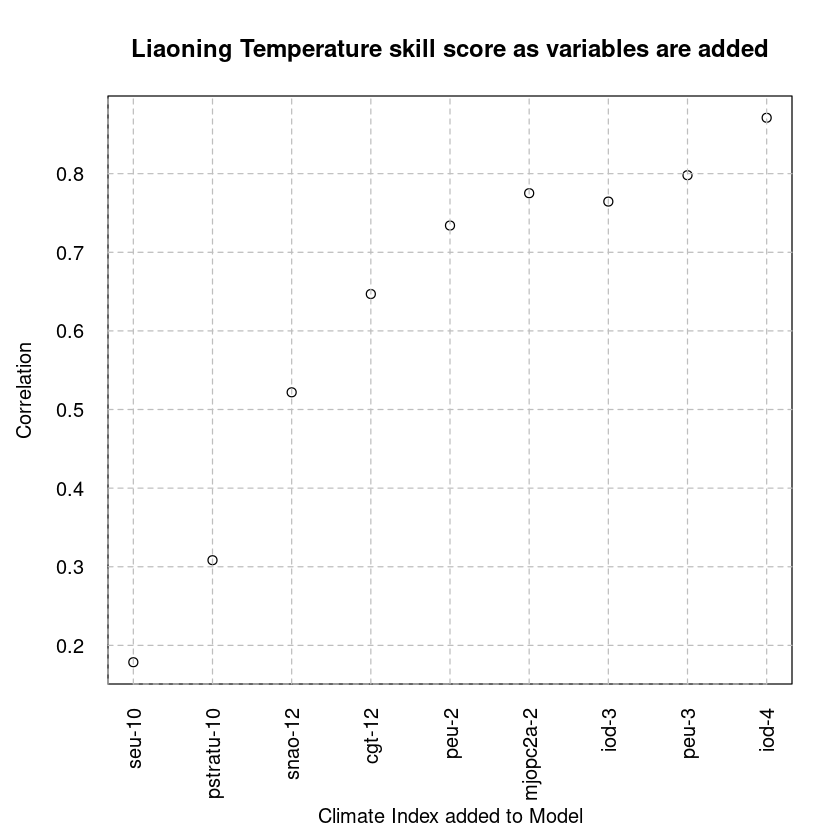

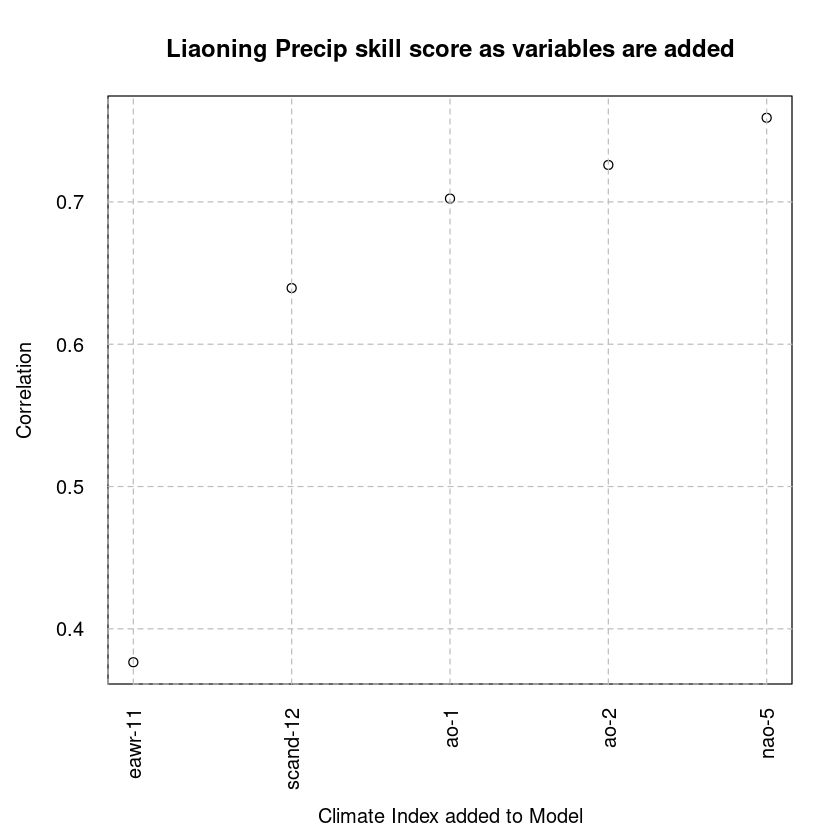

[1] "No need for plot with 1 precip predictor for Jilin"
[1] "Total skill score Jilin precip =  0.377532769197189"


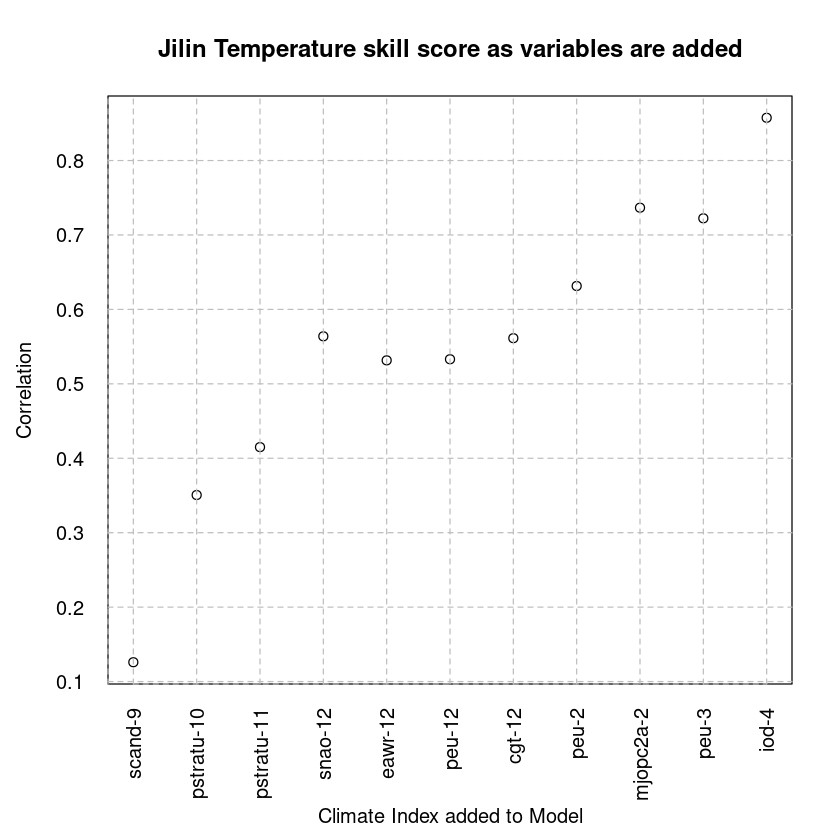

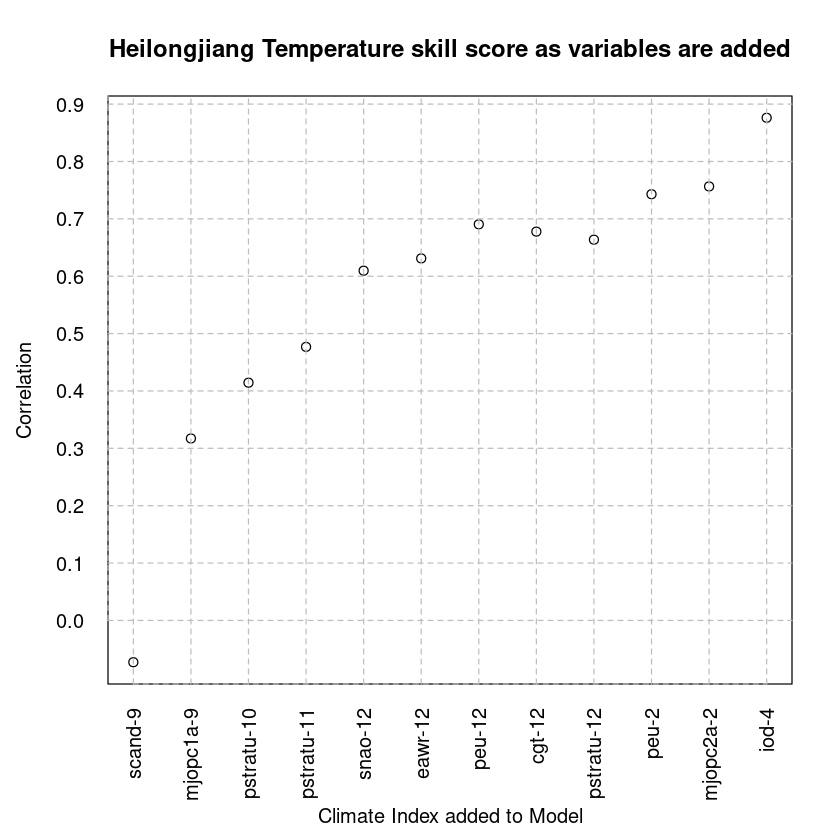

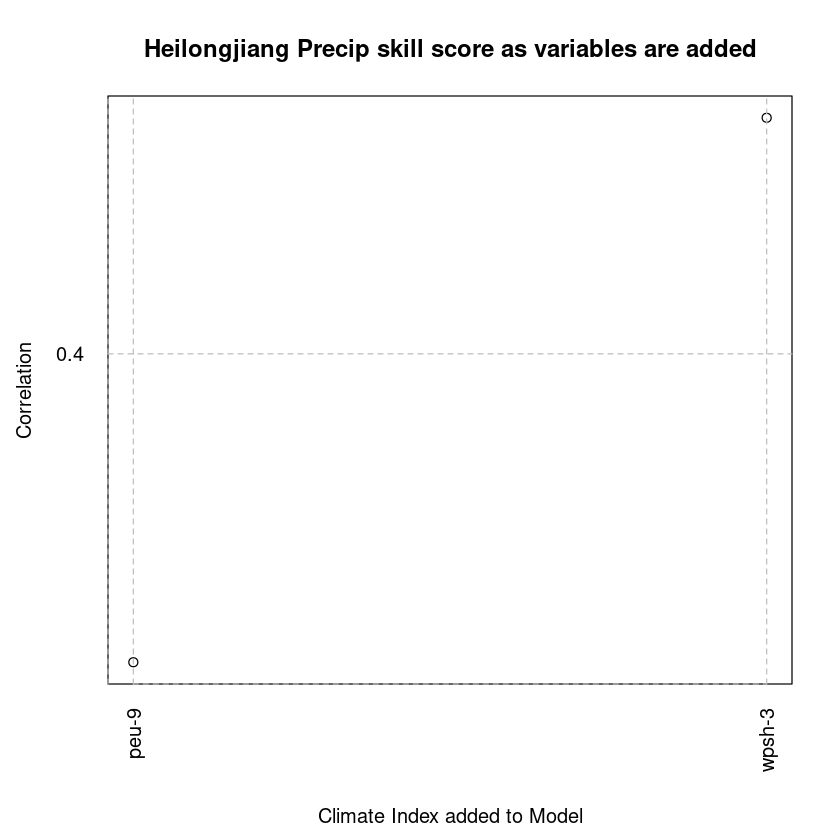

In [ ]:
all_scores_T = c()
all_scores_P = c()
t_loocv = create_empty_dataframe(rownames(temp_jja), regs)
p_loocv = create_empty_dataframe(rownames(temp_jja), regs)
years <- rownames(cindex_anoms)

for (k in 1:length(regs)) {
    scores = as.numeric(0)
    scores_P = as.numeric(0)
    # get the T and P indexs of significant varibles 
    t_inds = gsub("[[:punct:]]", "-", t_parent[[k]])
    p_inds = gsub("[[:punct:]]", "-", p_parent[[k]])

    if (length(t_inds) == 1) {
        print(paste("No need for plot with 1 temperature predictor for",regs[k]))
        print(paste("Total skill score", regs[k], "temperature = ", cor(t_loocv_red[, k], temp_anoms[,k])))
    } else { 
    df_for_temp_prediction = sort_df_cols_on_month(cindex_anoms[,t_inds], mon_list)
    
    
    for (col_index in 1:length(colnames(df_for_temp_prediction))) {
    new_var_added_T = colnames(df_for_temp_prediction)[col_index]
    df_to_use_T = data.frame(df_for_temp_prediction[, 1:col_index])
    colnames(df_to_use_T) <- colnames(df_for_temp_prediction)[1:col_index]
    
    
        for (y in 1:length(years)) {
            #print(y)
            rind = y
            tt = 1:length(temp_jja[-rind,k]) 
            lmmodt = lm(temp_jja[-rind,k] ~ tt) # temp_jja[-rind, k] ~ tt # gets all the years other than -rind for that area
            lmmodp = lm(temp_jja[-rind,k] ~ tt)
            

            # get mean T/P for the missing year    
            ttout_of_sample_data <- data.frame(tt = t(rind))
            tmean_pred = predict(lmmodt, ttout_of_sample_data, se.fit = TRUE)$fit

            if (length(t_inds) > 0) {
                tmod = automate_predict_new_test("t", lmmodt$residuals, df_to_use_T[-rind, ], df_to_use_T[rind,])
                tmod_fit = tmod$model$fitted.values
                t_loocv[y,k] = tmod$pred

            }

        }
    
    scores = rbind(scores, cbind(new_var_added_T, cor(t_loocv[, k], temp_anoms[,k])))
    }
    scores = scores[-1,]
    scores <- data.frame(scores)
    colnames(scores) <- c('Variable_added', 'Score')
    rownames(scores) <- scores$Variable_added
    #print(scores$Score)
    all_scores_T[[regs[k]]] = scores
    fig.dim = c(8, 8)
    par(mar=c(6.5,4.5,4,2))
    plot(x = 1:length(scores$Variable_added), 
         y = as.numeric(as.character(scores$Score)),
         xaxt = "n",
         yaxt = "n",
        ylab="Correlation",
        xlab="")
    axis(1, at = seq(1,length(scores$Variable_added),1),
         labels=scores$Variable_added , las=2, tck = 1, lty = 2, col = "grey")
    axis(2, at = seq(0,1,0.1), las=2, tck = 1, lty = 2, col = "grey")
    title(xlab = "Climate Index added to Model", line = 5) 
    title(main = paste(regs[k],"Temperature skill score as variables are added"))
    }
    
    if (length(p_inds) == 1) {
        print(paste("No need for plot with 1 precip predictor for",regs[k]))
        print(paste("Total skill score", regs[k], "precip = ", cor(p_loocv_red[, k], precip_anoms[,k])))
    } else { 
    df_for_precip_prediction = sort_df_cols_on_month(cindex_anoms[,p_inds], mon_list)
        
    
    for (col_index in 1:length(colnames(df_for_precip_prediction))) {
    new_var_added_P = colnames(df_for_precip_prediction)[col_index]
    df_to_use_P = data.frame(df_for_precip_prediction[, 1:col_index])
    colnames(df_to_use_P) <- colnames(df_for_precip_prediction)[1:col_index]
    
    
        for (y in 1:length(years)) {
            #print(y)
            rind = y
            tt = 1:length(precip_jja[-rind,k]) 
            lmmodt = lm(precip_jja[-rind,k] ~ tt) # temp_jja[-rind, k] ~ tt # gets all the years other than -rind for that area
            lmmodp = lm(precip_jja[-rind,k] ~ tt)
            

            # get mean T/P for the missing year    
            ttout_of_sample_data <- data.frame(tt = t(rind))
            pmean_pred = predict(lmmodp, ttout_of_sample_data, se.fit = TRUE)$fit

            if (length(p_inds) > 0) {
                pmod = automate_predict_new_test("p", lmmodp$residuals, df_to_use_P[-rind,], df_to_use_P[rind,])
                pmod_fit = pmod$model$fitted.values
                p_loocv[y,k] = pmod$pred
            }

        }
    
    scores_P= rbind(scores_P, cbind(new_var_added_P, cor(p_loocv[, k], precip_anoms[,k])))
    }
    scores_P = scores_P[-1,]
    scores_P <- data.frame(scores_P)
    colnames(scores_P) <- c('Variable_added', 'Score')
    rownames(scores_P) <- scores_P$Variable_added
    #print(scores$Score)
    all_scores_P[[regs[k]]] = scores_P
    fig.dim = c(8, 8)
    par(mar=c(6.5,4.5,4,2))
    plot(x = 1:length(scores_P$Variable_added), 
         y = as.numeric(as.character(scores_P$Score)),
         xaxt = "n",
         yaxt = "n",
        ylab="Correlation",
        xlab="")
    axis(1, at = seq(1,length(scores_P$Variable_added),1),
         labels=scores_P$Variable_added , las=2, tck = 1, lty = 2, col = "grey")
    axis(2, at = seq(0,1,0.1), las=2, tck = 1, lty = 2, col = "grey")
    title(xlab = "Climate Index added to Model", line = 5) 
    title(main = paste(regs[k],"Precip skill score as variables are added"))
    }
}

### Explainability plots 

In [ ]:
# create plot to show variable selection
tpc = prcomp((temp_anoms))
ppc = prcomp((precip_anoms))

tvar_exp = 100.0*signif(tpc$sdev/sum(tpc$sdev), digits=2)
pvar_exp = 100.0*signif(ppc$sdev/sum(ppc$sdev), digits=2)

#  correlated temperature predictors with the first two 
tcors1_all = cor(cindex_anoms, tpc$x[,1])
tcors2_all = cor(cindex_anoms, tpc$x[,2])
tcors1 = cor(cindex_anoms[,t_inds_all], tpc$x[,1])
tcors2 = cor(cindex_anoms[,t_inds_all], tpc$x[,2])

pcors1_all = cor(cindex_anoms, ppc$x[,1])
pcors2_all = cor(cindex_anoms, ppc$x[,2])
pcors1 = cor(cindex_anoms[,p_inds_all], ppc$x[,1])
pcors2 = cor(cindex_anoms[,p_inds_all], ppc$x[,2])


#  dev.new()
#png(paste('./', region,'_tpca_',ystrts,'_',yends,"_lag_",lag,"_",suffix,'.png', sep=""),width=16.25,height=12.25,units="in",res=400)
#  , bg = "transparent"
#  par(mfrow=c(1,2))
par(mar=c(7,7,4,4))
plot(sqrt(tpc$rotation[,1]^2), sqrt(tpc$rotation[,2]^2), xlim=c(0,0.8), ylim=c(0,0.9),
     cex=3, cex.lab = 2.5, cex.axis=2.5, 
     xlab=paste("Correlation with Temperature - PC1 (", tvar_exp[1], "%)", sep=""), 
     ylab=paste("Correlation with Temperature PC2 (", tvar_exp[2], "%)", sep=""), pch=1)
text(sqrt(tpc$rotation[,1]^2), sqrt(tpc$rotation[,2]^2), labels=regs, cex= 2.0, pos=3)
points(sqrt(tcors1_all^2), sqrt(tcors2_all^2), col='gray', pch=2)
points(sqrt(tcors1^2), sqrt(tcors2^2), col='orange', pch=2)
text(sqrt(tcors1^2), sqrt(tcors2^2), labels=colnames(cindex_anoms[, t_inds_all]), cex= 2.0, pos=3)
legend("topleft", cex=2.0, legend = c("Obs Temp", "Climate Indices", "Climate Indices (selected)"),
       pch=c(1,2,2), col=c("black", "gray", "orange"))
#dev.off()


#png(paste('./', region,'_ppca_',ystrts,'_',yends,"_lag_",lag,"_",suffix,'.png', sep=""),width=16.25,height=12.25,units="in",res=300)
par(mar=c(7,7,4,4))
plot(sqrt(ppc$rotation[,1]^2), sqrt(ppc$rotation[,2]^2), xlim=c(0,0.8), ylim=c(0,0.9), 
     cex=2, cex.lab = 2, cex.axis=2, 
     xlab=paste("Correlation with Precipitation - PC1 (", pvar_exp[1], "%)", sep=""),
     ylab=paste("Correlation with Precipitation - PC2 (", pvar_exp[2], "%)", sep=""), pch=1)
text(sqrt(ppc$rotation[,1]^2), sqrt(ppc$rotation[,2]^2), labels=regs, cex= 1.5, pos=3)
points(sqrt(pcors1_all^2), pcors2_all^2, col='gray', pch=2)
points(sqrt(pcors1^2), sqrt(pcors2^2), col='orange', pch=2)
text(sqrt(pcors1^2), sqrt(pcors2^2), labels=colnames(cindex_anoms[, p_inds_all]), cex= 1.5, pos=3)
legend("topleft", legend = c("Obs Precip", "Climate Indices", "Climate Indices (selected)"), 
       pch=c(1,2,2), col=c("black", "gray", "orange"), cex=1.5)
#dev.off()

### Bootstrapping confidence intervals 

In [ ]:
library(boot)

In [ ]:
boot_cor <- function(data, indices) {
    d <- data[indices,]
    cor()
    return (cor_whatever)
}

In [ ]:
head(temp_anoms)

Liaoning-T,Jilin-T,Heilongjiang-T
0.4767537,-0.07799843,-0.53412111
1.0461054,1.81619148,2.06508026
-0.1926158,-1.65087332,-2.06402876
0.3694542,0.28934417,-0.02428095
-0.1619110,0.11110493,0.11437196
-1.1381192,-0.94495550,-0.37800865


In [ ]:

fcast_no_jet = read.csv("/net/home/h06/epope/climate_security/python_code/HCCP/china_fcast_temp_anoms_JJA_lag_0.csv"
         , header = TRUE,sep = ",", stringsAsFactors = FALSE)  

In [ ]:
head(fcast_no_jet[, -1])

,Liaoning,Jilin,Heilongjiang
,<dbl>,<dbl>,<dbl>
1,0.28304739,0.6290482,-0.03177261
2,0.63285838,0.4775292,0.94215132
3,0.07666741,-0.8564212,-0.56686453
4,0.04303112,0.1457353,0.57736689
5,0.42814734,0.9633850,0.80497997
6,-0.28179202,-0.7051890,-0.10653735


In [ ]:
liaoning_data = cbind(fcast_no_jet[,'Liaoning'], temp_anoms[,'Liaoning-T'])
jilin_data = cbind(fcast_no_jet[,'Jilin'], temp_anoms[,'Jilin-T'])
heilongjiang_data = cbind(fcast_no_jet[,'Heilongjiang'], temp_anoms[,'Heilongjiang-T'])

In [ ]:
cor(liaoning_data[,1], liaoning_data[,2])

[1] 0.8211218

In [ ]:
function_1 <- function(data, i){
 d <- data[i,] 
 return(cor(d[,1], d[,2]))
}

#### Liaoning 

In [ ]:
set.seed(1)
bootstrap_correlation <- boot(liaoning_data,function_1,R=1000)

In [ ]:
bootstrap_correlation


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = liaoning_data, statistic = function_1, R = 1000)


Bootstrap Statistics :
     original       bias    std. error
t1* 0.8211218 -0.004189638  0.06141371

In [ ]:
boot.ci(boot.out=bootstrap_correlation)

Warning message in boot.ci(boot.out = bootstrap_correlation):
"bootstrap variances needed for studentized intervals"


BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = bootstrap_correlation)

Intervals : 
Level      Normal              Basic         
95%   ( 0.7049,  0.9457 )   ( 0.7394,  0.9729 )  

Level     Percentile            BCa          
95%   ( 0.6694,  0.9029 )   ( 0.6363,  0.8978 )  
Calculations and Intervals on Original Scale

#### Jilin 

In [ ]:
set.seed(1)
bootstrap_Jilin <- boot(jilin_data,function_1,R=1000)
print(bootstrap_Jilin)
print(boot.ci(boot.out=bootstrap_Jilin))


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = jilin_data, statistic = function_1, R = 1000)


Bootstrap Statistics :
     original      bias    std. error
t1* 0.7420534 0.004217224  0.07536096


Warning message in boot.ci(boot.out = bootstrap_Jilin):
"bootstrap variances needed for studentized intervals"


BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = bootstrap_Jilin)

Intervals : 
Level      Normal              Basic         
95%   ( 0.5901,  0.8855 )   ( 0.6150,  0.9058 )  

Level     Percentile            BCa          
95%   ( 0.5783,  0.8691 )   ( 0.4800,  0.8524 )  
Calculations and Intervals on Original Scale
Some BCa intervals may be unstable


#### Heilongjiang

In [ ]:
set.seed(1)
bootstrap_heilongjiang <- boot(heilongjiang_data,function_1,R=1000)
print(bootstrap_heilongjiang)
print(boot.ci(boot.out=bootstrap_heilongjiang))


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = heilongjiang_data, statistic = function_1, R = 1000)


Bootstrap Statistics :
     original      bias    std. error
t1* 0.6967452 0.004085927  0.06454376


Warning message in boot.ci(boot.out = bootstrap_heilongjiang):
"bootstrap variances needed for studentized intervals"


BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = bootstrap_heilongjiang)

Intervals : 
Level      Normal              Basic         
95%   ( 0.5662,  0.8192 )   ( 0.5731,  0.8230 )  

Level     Percentile            BCa          
95%   ( 0.5705,  0.8204 )   ( 0.5572,  0.8077 )  
Calculations and Intervals on Original Scale


### with Jets 

In [ ]:
fcast_jet = read.csv("/net/home/h06/epope/climate_security/python_code/HCCP/china_fcast_temp_anoms_red_JJA_lag_0.csv"
         , header = TRUE,sep = ",", stringsAsFactors = FALSE)  

In [ ]:
head(fcast_jet)

,X,Liaoning,Jilin,Heilongjiang
,<int>,<dbl>,<dbl>,<dbl>
1,1981,0.1484943,0.442664534,0.35671256
2,1982,0.4940587,0.486733872,0.57499719
3,1983,-0.1694563,-0.546983294,-0.86534339
4,1984,-0.1137297,-0.002702875,-0.02792253
5,1985,-0.9596029,-0.598009051,-0.39688159
6,1986,0.1826624,-0.064899170,0.19258362


In [ ]:
liaoning_data = cbind(fcast_jet[,'Liaoning'], temp_anoms[,'Liaoning-T'])
jilin_data = cbind(fcast_jet[,'Jilin'], temp_anoms[,'Jilin-T'])
heilongjiang_data = cbind(fcast_jet[,'Heilongjiang'], temp_anoms[,'Heilongjiang-T'])

#### Liaoning 

In [ ]:
set.seed(1)
bootstrap_liaoning <- boot(liaoning_data,function_1,R=1000)
print(bootstrap_liaoning)
print(boot.ci(boot.out=bootstrap_liaoning))


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = liaoning_data, statistic = function_1, R = 1000)


Bootstrap Statistics :
     original      bias    std. error
t1* 0.6186866 0.002705464  0.09200868


Warning message in boot.ci(boot.out = bootstrap_liaoning):
"bootstrap variances needed for studentized intervals"


BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = bootstrap_liaoning)

Intervals : 
Level      Normal              Basic         
95%   ( 0.4356,  0.7963 )   ( 0.4585,  0.8330 )  

Level     Percentile            BCa          
95%   ( 0.4043,  0.7789 )   ( 0.3695,  0.7634 )  
Calculations and Intervals on Original Scale


In [ ]:
0.62 + 0.18

[1] 0.8

#### Jilin

In [ ]:
set.seed(1)
bootstrap_Jilin <- boot(jilin_data,function_1,R=1000)
print(bootstrap_Jilin)
print(boot.ci(boot.out=bootstrap_Jilin))


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = jilin_data, statistic = function_1, R = 1000)


Bootstrap Statistics :
     original      bias    std. error
t1* 0.6309198 0.008517417  0.07996893


Warning message in boot.ci(boot.out = bootstrap_Jilin):
"bootstrap variances needed for studentized intervals"


BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = bootstrap_Jilin)

Intervals : 
Level      Normal              Basic         
95%   ( 0.4657,  0.7791 )   ( 0.4819,  0.7896 )  

Level     Percentile            BCa          
95%   ( 0.4722,  0.7799 )   ( 0.3864,  0.7582 )  
Calculations and Intervals on Original Scale
Some BCa intervals may be unstable


In [ ]:
0.65 + 0.16

[1] 0.81

#### Heilongjiang 

In [ ]:
set.seed(1)
bootstrap_heilongjiang <- boot(heilongjiang_data,function_1,R=1000)
print(bootstrap_heilongjiang)
print(boot.ci(boot.out=bootstrap_heilongjiang))


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = heilongjiang_data, statistic = function_1, R = 1000)


Bootstrap Statistics :
     original      bias    std. error
t1* 0.5974958 0.007689333  0.07639934


Warning message in boot.ci(boot.out = bootstrap_heilongjiang):
"bootstrap variances needed for studentized intervals"


BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = bootstrap_heilongjiang)

Intervals : 
Level      Normal              Basic         
95%   ( 0.4401,  0.7395 )   ( 0.4521,  0.7521 )  

Level     Percentile            BCa          
95%   ( 0.4429,  0.7429 )   ( 0.4052,  0.7209 )  
Calculations and Intervals on Original Scale


### Seasonal forecast  

In [ ]:
datadir = '/data/users/ncreaser/CSSP_china/data/seasonal_forecast/DePreSys_NE_China_provinces_weighted_detrended_1981_2016.csv'
depresys = read.csv(datadir, header = TRUE,sep = ",", stringsAsFactors = FALSE) 

In [ ]:
liaoning_data = cbind(depresys[,'Liaoning'], temp_anoms[,'Liaoning-T'])
jilin_data = cbind(depresys[,'Jilin'], temp_anoms[,'Jilin-T'])
heilongjiang_data = cbind(depresys[,'Heilongjiang'], temp_anoms[,'Heilongjiang-T'])

In [ ]:
set.seed(1)
bootstrap_liaoning <- boot(liaoning_data,function_1,R=1000)
print(bootstrap_liaoning)
print(boot.ci(boot.out=bootstrap_liaoning))


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = liaoning_data, statistic = function_1, R = 1000)


Bootstrap Statistics :
     original      bias    std. error
t1* 0.2696603 0.007538836   0.1343295


Warning message in boot.ci(boot.out = bootstrap_liaoning):
"bootstrap variances needed for studentized intervals"


BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = bootstrap_liaoning)

Intervals : 
Level      Normal              Basic         
95%   (-0.0012,  0.5254 )   ( 0.0085,  0.5352 )  

Level     Percentile            BCa          
95%   ( 0.0041,  0.5308 )   (-0.0387,  0.4985 )  
Calculations and Intervals on Original Scale


In [ ]:
set.seed(1)
bootstrap_Jilin <- boot(jilin_data,function_1,R=1000)
print(bootstrap_Jilin)
print(boot.ci(boot.out=bootstrap_Jilin))


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = jilin_data, statistic = function_1, R = 1000)


Bootstrap Statistics :
     original        bias    std. error
t1* 0.2924243 -0.0006353441   0.1422674


Warning message in boot.ci(boot.out = bootstrap_Jilin):
"bootstrap variances needed for studentized intervals"


BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = bootstrap_Jilin)

Intervals : 
Level      Normal              Basic         
95%   ( 0.0142,  0.5719 )   ( 0.0295,  0.5958 )  

Level     Percentile            BCa          
95%   (-0.0109,  0.5553 )   ( 0.0057,  0.5577 )  
Calculations and Intervals on Original Scale


In [ ]:
set.seed(1)
bootstrap_heilongjiang <- boot(heilongjiang_data,function_1,R=1000)
print(bootstrap_heilongjiang)
print(boot.ci(boot.out=bootstrap_heilongjiang))


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = heilongjiang_data, statistic = function_1, R = 1000)


Bootstrap Statistics :
     original       bias    std. error
t1* 0.2445439 0.0007686634   0.1668556


Warning message in boot.ci(boot.out = bootstrap_heilongjiang):
"bootstrap variances needed for studentized intervals"


BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = bootstrap_heilongjiang)

Intervals : 
Level      Normal              Basic         
95%   (-0.0833,  0.5708 )   (-0.0734,  0.5648 )  

Level     Percentile            BCa          
95%   (-0.0757,  0.5625 )   (-0.0893,  0.5510 )  
Calculations and Intervals on Original Scale
